In [1]:
# Import libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import sklearn.tree as tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve
import scipy.stats.stats as stat

In [2]:
# set max number of rows to diplay in panadas output

pd.set_option('display.max_rows', 1000)

In [3]:
# create folder for outputs

try:
    os.mkdir('output')
    print('Created sucessfully') 
except FileExistsError:
    print('Already exists')

Already exists


In [4]:
#Define functions

# Define function for plotting variable distribution
def plot_dist(vars):
    for x in vars:    
        fig, ax = plt.subplots(figsize=(6, 6))
        plot = sns.distplot(df[x].fillna(0), kde=False, ax=ax)
        plt.title(x)
        plt.xlabel(x)
        plt.ylabel('Frequency')
        plt.show()
        plot.get_figure().savefig('output/' + x + '_dist.png')
    return

# Define function for plotting variable x default rate
def plot_def_rate(vars, target, n):

    N = n

    for v in vars:
        temp = df[[v,target]].fillna(-99).sort_values(by = v, ascending = True).reset_index(drop = True)
        x = np.convolve(temp[v], np.ones((N,))/N, mode='valid')
        x2 = list(temp.index)[:-N+1]
        y = np.convolve(temp[target], np.ones((N,))/N, mode='valid')
        fig, ax = plt.subplots(figsize=(6, 6))
        plot = sns.lineplot(x[::N],y[::N], ax=ax)
        plt.title(v)
        plt.xlabel(v)
        plt.ylabel('Default rate')
        plt.show()
        plot.get_figure().savefig('output/' + v + '_def_rate_by_value.png')
        print(v, '- by value')
        fig, ax = plt.subplots(figsize=(6, 6))
        plot = sns.lineplot(x2[::N],y[::N], ax=ax)
        plt.title(v)
        plt.xlabel('Observation numeber')
        plt.ylabel('Default rate')
        plt.show()
        plot.get_figure().savefig('output/' + v + '_def_rate_by_index.png')
        print(v, '- by index')
        print('-'*40)
    return

# Calculate univariate auc with decision tree model
def uni_auc(vars ,target, tree_depth, tree_max_node, tree_min_leaf):
    varlist = []
    auclist = []
    for v in vars:
        tree_model = tree.DecisionTreeClassifier(max_depth = tree_depth, 
                                                 max_leaf_nodes = tree_max_node, 
                                                 min_samples_leaf = tree_min_leaf)
        tree_model.fit(X = df[[v]], y = df[target])
        tree_output = tree_model.predict_proba(df[[v]])[:,1]
        auc = roc_auc_score(df[target], tree_output)
        varlist.append(v)
        auclist.append(auc)
    output = pd.DataFrame()
    output['variable'] = varlist
    output['auc'] = auclist
    return output

In [5]:
# read data from csv file

df = pd.read_csv('cs-training.csv').iloc[:, 1:]

In [6]:
# check data has imported as expected

print(df.dtypes)
print('-'*40)
df.head()

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object
----------------------------------------


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [7]:
# Define list of column names

col_names = df.columns.sort_values()
col_target = df.columns[0]
col_vars = df.columns[1:].sort_values()

list(col_vars)

['DebtRatio',
 'MonthlyIncome',
 'NumberOfDependents',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'RevolvingUtilizationOfUnsecuredLines',
 'age']

In [8]:
# Key data statistics

print('Number of observations: ', df.shape[0])
print('Number of variables: ', df.shape[1])
print('Number of defaults: ', df[col_target].sum())
print('Default rate: ', "{:.2%}".format(df[col_target].mean()))

Number of observations:  150000
Number of variables:  11
Number of defaults:  10026
Default rate:  6.68%


In [9]:
# Get high level view of observations

df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


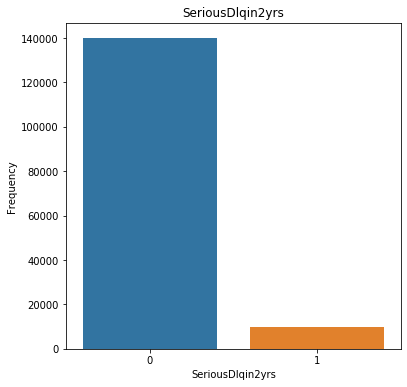

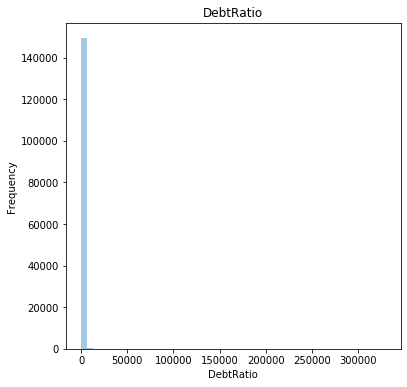

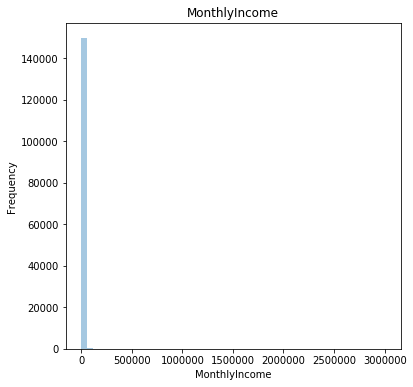

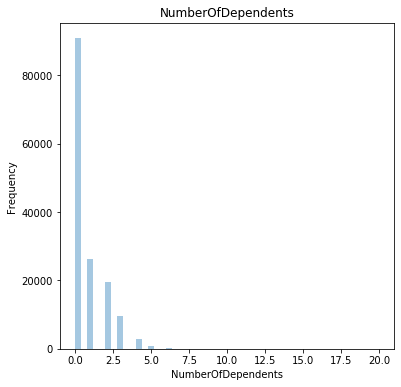

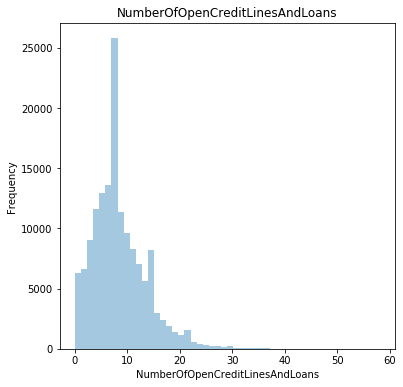

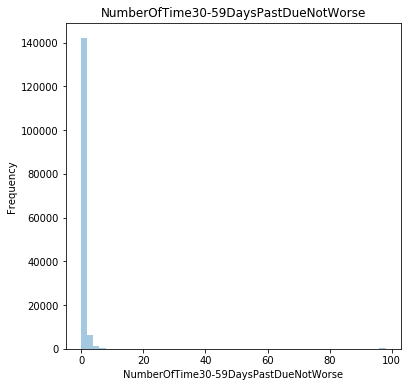

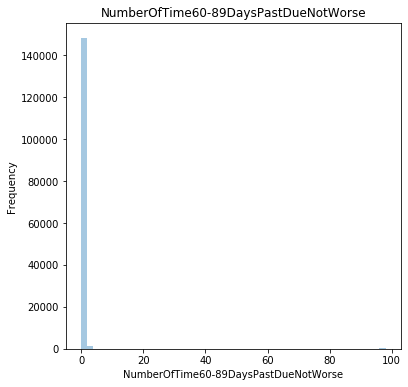

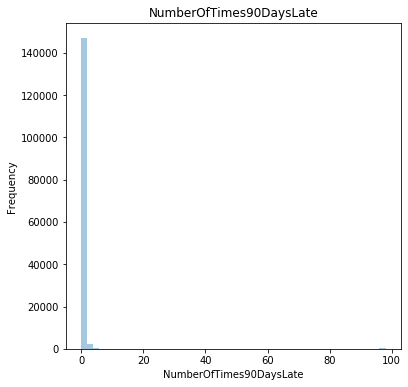

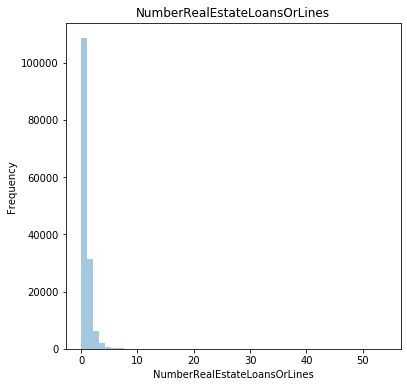

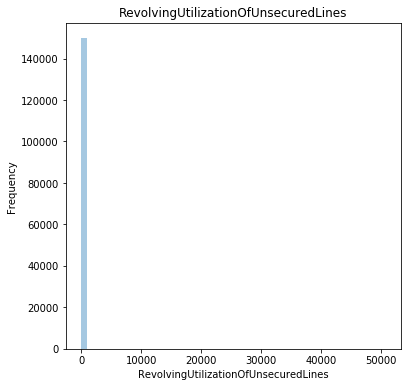

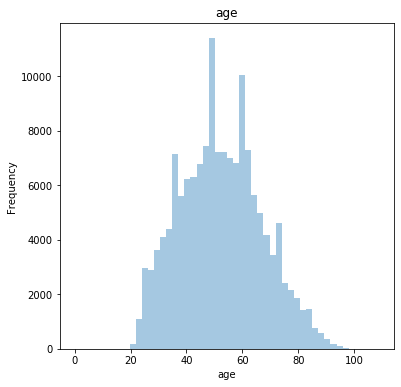

In [10]:
# Plot distributions of variables

# Plot target dist
fig, ax = plt.subplots(figsize=(6, 6))
plot = sns.countplot(df[col_target], ax=ax)
plt.title(col_target)
plt.xlabel(col_target)
plt.ylabel('Frequency')
plt.show()
plot.get_figure().savefig('output/' + col_target + '_dist.png')

# Plot variable dist
plot_dist(col_vars)

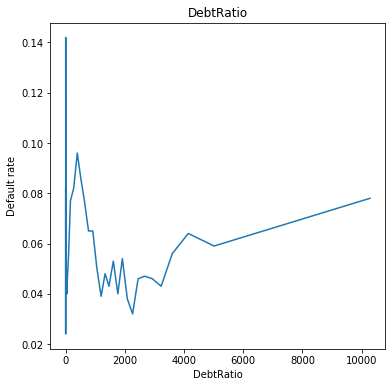

DebtRatio - by value


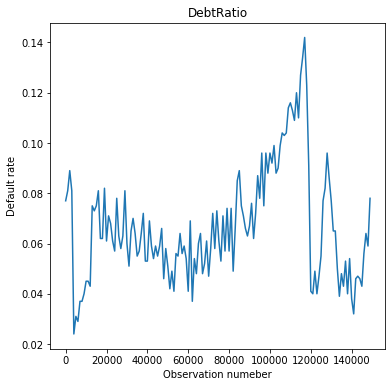

DebtRatio - by index
----------------------------------------


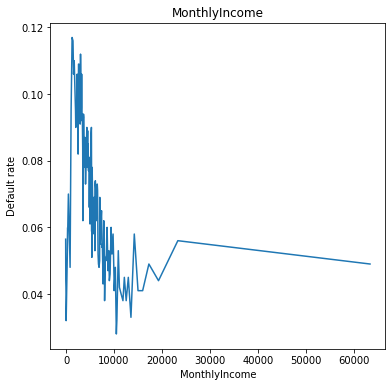

MonthlyIncome - by value


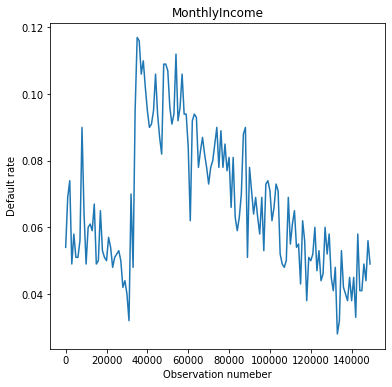

MonthlyIncome - by index
----------------------------------------


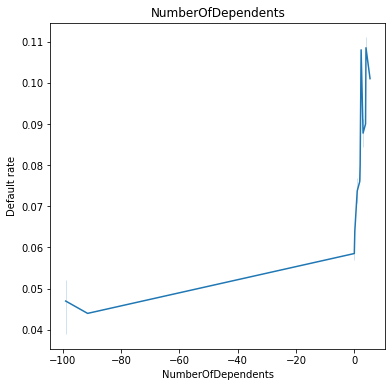

NumberOfDependents - by value


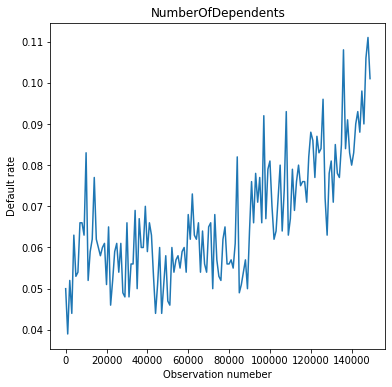

NumberOfDependents - by index
----------------------------------------


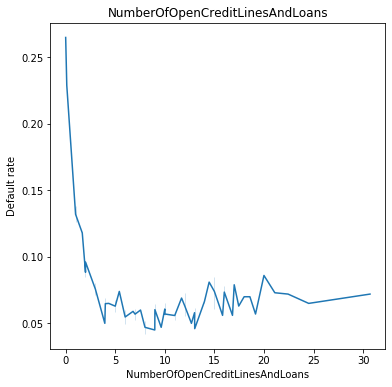

NumberOfOpenCreditLinesAndLoans - by value


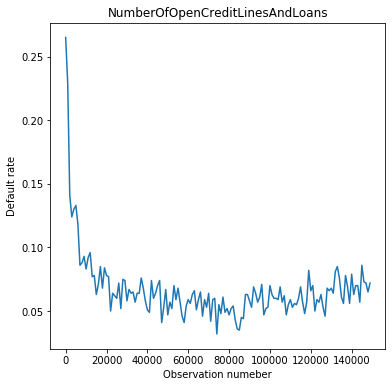

NumberOfOpenCreditLinesAndLoans - by index
----------------------------------------


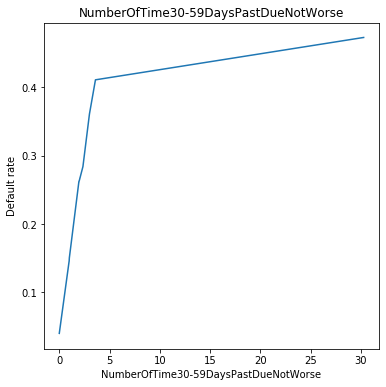

NumberOfTime30-59DaysPastDueNotWorse - by value


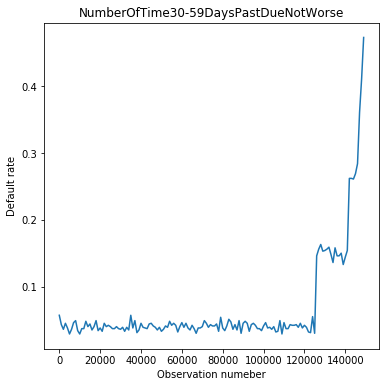

NumberOfTime30-59DaysPastDueNotWorse - by index
----------------------------------------


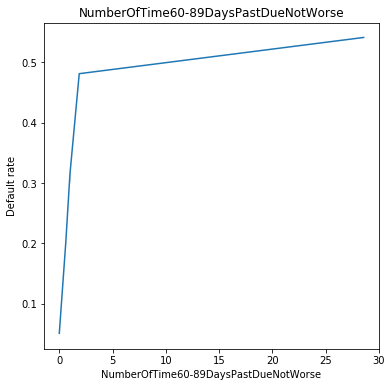

NumberOfTime60-89DaysPastDueNotWorse - by value


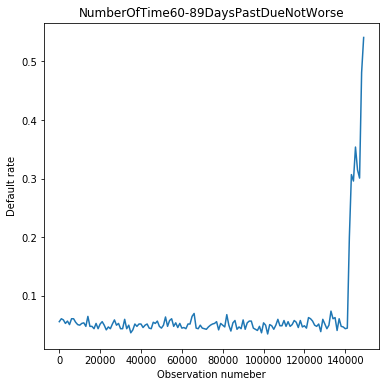

NumberOfTime60-89DaysPastDueNotWorse - by index
----------------------------------------


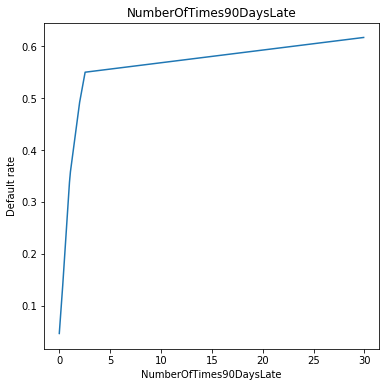

NumberOfTimes90DaysLate - by value


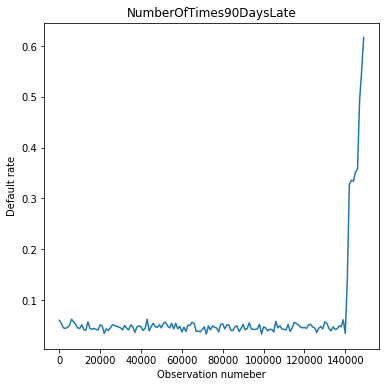

NumberOfTimes90DaysLate - by index
----------------------------------------


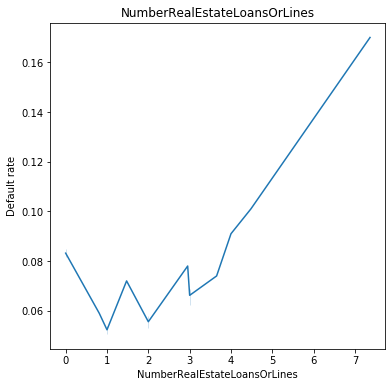

NumberRealEstateLoansOrLines - by value


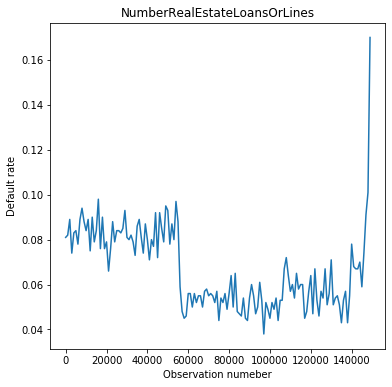

NumberRealEstateLoansOrLines - by index
----------------------------------------


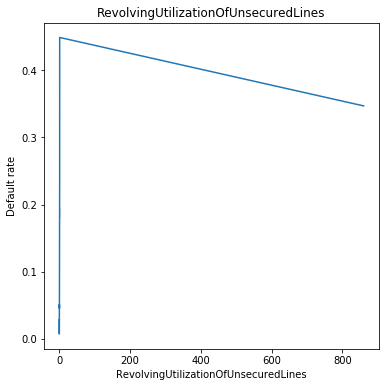

RevolvingUtilizationOfUnsecuredLines - by value


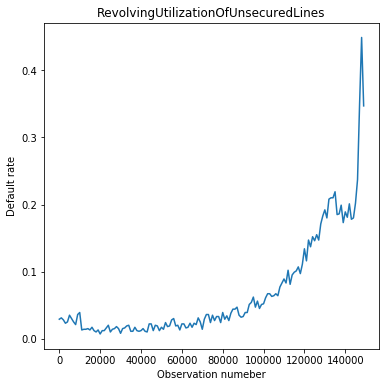

RevolvingUtilizationOfUnsecuredLines - by index
----------------------------------------


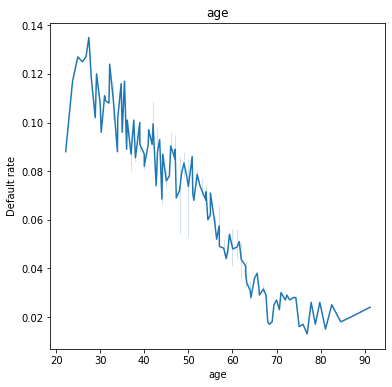

age - by value


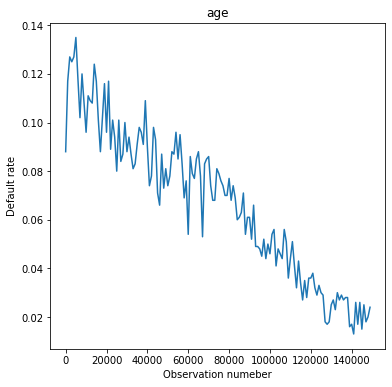

age - by index
----------------------------------------


In [11]:
# Plot default rate by variable

plot_def_rate(col_vars, col_target, 1000)

In [12]:
# Take a look at the data

# Order by acsending
asc = True

# Show num rows
num = 20

# Display outut for all sorted variables
for x in col_vars:
    print(x)
    display(df.sort_values(by = x, ascending = asc).reset_index(drop = True).head(num))
    print('')
    print('-'*40)

DebtRatio


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.0,42,0,0.0,3980.0,4,0,0,0,1.0
1,0,1.0,52,98,0.0,3700.0,0,98,0,98,0.0
2,0,1.0,74,0,0.0,3000.0,0,0,0,0,0.0
3,0,0.0,91,0,0.0,NaN,1,0,0,0,NaN
4,0,1.0,43,0,0.0,NaN,0,0,0,0,0.0
5,0,0.0,84,0,0.0,2132.0,4,0,0,0,0.0
6,0,1.0,56,0,0.0,NaN,0,0,0,0,1.0
7,0,0.0,27,0,0.0,NaN,2,0,0,0,NaN
8,0,1.0,34,0,0.0,1200.0,0,2,0,0,0.0
9,0,0.0,62,0,0.0,2783.0,2,0,0,0,0.0



----------------------------------------
MonthlyIncome


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.248989,64,0,4053.0,0.0,16,0,2,0,0.0
1,0,1.000000,46,0,0.0,0.0,1,0,0,0,1.0
2,0,0.574776,41,0,1436.0,0.0,11,0,0,0,0.0
3,0,0.200381,23,0,12.0,0.0,3,0,0,0,0.0
4,0,0.923749,40,3,3122.0,0.0,6,1,2,2,2.0
5,0,0.194640,43,0,4139.0,0.0,5,0,1,0,3.0
6,0,0.033814,48,0,2663.0,0.0,13,0,2,0,2.0
7,0,0.102870,40,0,1953.0,0.0,5,0,1,0,0.0
8,0,0.095059,63,0,2173.0,0.0,11,0,1,0,0.0
9,0,1.000000,59,0,1046.0,0.0,2,6,2,0,2.0



----------------------------------------
NumberOfDependents


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.850283,64,0,0.249908,8158.0,8,0,2,0,0.0
1,0,1.000000,26,0,0.108919,3800.0,4,1,0,1,0.0
2,0,0.157095,82,1,0.138071,3700.0,12,0,0,0,0.0
3,0,1.000000,27,0,0.276777,3883.0,5,0,1,0,0.0
4,0,0.252737,64,0,0.902681,1715.0,6,0,2,0,0.0
5,0,0.267273,42,0,0.403760,10000.0,5,0,2,0,0.0
6,0,0.033706,50,0,0.009898,3636.0,5,0,0,0,0.0
7,0,0.000000,56,0,0.091193,1600.0,3,0,0,0,0.0
8,0,0.170366,51,0,0.433290,17590.0,13,0,5,0,0.0
9,0,0.009782,74,0,0.001778,5622.0,5,0,0,0,0.0



----------------------------------------
NumberOfOpenCreditLinesAndLoans


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,1.0,37,0,0.000000,NaN,0,0,0,0,NaN
1,0,1.0,26,0,0.000000,NaN,0,0,0,0,NaN
2,0,1.0,25,0,0.000000,NaN,0,0,0,0,0.0
3,0,1.0,22,98,0.000000,NaN,0,98,0,98,0.0
4,1,1.0,30,0,0.000000,2200.0,0,2,0,0,3.0
5,0,1.0,32,0,0.000000,4400.0,0,2,0,0,0.0
6,0,1.0,26,0,0.000000,2000.0,0,0,0,0,0.0
7,0,1.0,44,0,0.000000,4000.0,0,2,0,0,0.0
8,0,1.0,36,0,0.003818,2880.0,0,1,0,0,2.0
9,0,1.0,30,0,0.000000,1262.0,0,0,0,0,4.0



----------------------------------------
NumberOfTime30-59DaysPastDueNotWorse


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.019457,41,0,0.152130,6500.0,4,0,1,0,0.0
1,0,0.212068,33,0,0.189250,6250.0,11,0,0,0,0.0
2,0,0.068188,46,0,0.520154,8583.0,10,0,2,0,1.0
3,0,0.000000,70,0,1584.000000,NaN,3,0,1,0,0.0
4,0,0.016110,75,0,0.337666,4000.0,13,0,2,1,0.0
5,0,0.661723,63,0,0.261019,9301.0,9,0,0,0,0.0
6,0,0.982252,49,0,0.245209,5374.0,8,0,0,0,1.0
7,0,0.012033,55,0,71.000000,NaN,1,0,0,0,0.0
8,0,0.091298,53,0,0.233882,9833.0,11,3,1,0,1.0
9,0,0.395300,51,0,0.658042,3400.0,17,0,1,0,1.0



----------------------------------------
NumberOfTime60-89DaysPastDueNotWorse


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.664587,40,2,0.426877,5900.0,9,0,1,0,2.0
2,0,0.604701,66,0,0.592993,4166.0,15,0,1,0,0.0
3,0,0.242228,75,0,615.000000,NaN,7,0,0,0,NaN
4,0,0.000000,36,0,0.043510,8250.0,3,0,0,0,0.0
5,0,0.100959,87,0,0.674573,8600.0,12,0,3,0,1.0
6,0,0.231104,47,0,0.151308,6000.0,10,0,1,0,0.0
7,0,0.108005,80,0,0.189555,7084.0,14,0,1,0,0.0
8,0,0.000000,39,0,0.368666,3216.0,6,0,1,0,0.0
9,0,0.086738,40,0,0.123669,4600.0,10,0,1,0,2.0



----------------------------------------
NumberOfTimes90DaysLate


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.011403,56,0,0.237914,9700.0,8,0,2,0,1.0
2,0,0.089488,65,0,0.286346,15833.0,16,0,2,0,0.0
3,0,0.000000,35,0,0.448367,6458.0,7,0,2,0,0.0
4,0,0.091463,37,0,0.345182,3600.0,7,0,0,0,0.0
5,0,0.165922,42,1,0.105885,4400.0,5,0,0,0,2.0
6,0,0.812924,59,1,0.318296,7957.0,10,0,1,0,1.0
7,0,1.000000,70,0,0.429076,4250.0,5,0,1,0,2.0
8,1,0.915406,40,2,0.337266,10000.0,11,0,1,1,0.0
9,0,0.419958,51,0,795.000000,NaN,14,0,0,0,0.0



----------------------------------------
NumberRealEstateLoansOrLines


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.852016,22,0,0.644573,1040.0,5,0,0,0,0.0
1,0,0.944502,46,1,0.608370,1600.0,10,0,0,1,0.0
2,0,0.100334,53,0,0.021056,5888.0,4,0,0,0,2.0
3,0,0.142055,29,0,0.440446,2333.0,16,0,0,2,0.0
4,0,0.273854,47,0,0.010585,41000.0,13,0,0,0,2.0
5,0,0.480564,39,1,0.155401,4600.0,9,0,0,0,1.0
6,0,0.821151,31,0,0.176982,4604.0,15,0,0,0,1.0
7,0,0.180757,41,0,0.007450,20000.0,11,0,0,0,2.0
8,0,0.092802,85,1,40.000000,NaN,4,0,0,0,0.0
9,0,0.273242,25,0,0.179728,2130.0,4,0,0,0,0.0



----------------------------------------
RevolvingUtilizationOfUnsecuredLines


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.0,37,1,1.331517,1100.0,7,0,1,0,1.0
1,0,0.0,55,0,0.403899,4000.0,5,0,1,0,1.0
2,0,0.0,55,0,0.423394,4000.0,9,0,1,0,0.0
3,0,0.0,34,0,1159.000000,NaN,5,0,0,0,0.0
4,0,0.0,34,0,0.069323,6173.0,6,0,0,0,0.0
5,0,0.0,52,0,0.302621,14000.0,8,0,3,0,2.0
6,0,0.0,56,0,0.205727,6250.0,3,0,1,0,2.0
7,0,0.0,53,0,0.057334,5842.0,6,0,0,0,0.0
8,0,0.0,48,1,0.612572,3308.0,10,0,1,0,1.0
9,0,0.0,49,0,0.000000,3083.0,1,0,0,0,0.0



----------------------------------------
age


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,1.000000,0,1,0.436927,6000.0,6,0,2,0,2.0
1,0,0.000000,21,0,0.000000,800.0,1,0,0,0,0.0
2,0,0.000000,21,0,0.000000,1.0,1,0,0,0,1.0
3,0,0.292707,21,0,8.000000,0.0,2,0,0,0,0.0
4,0,0.055888,21,0,0.000000,NaN,1,0,0,0,NaN
5,0,0.843157,21,2,5.728587,898.0,7,2,2,1,0.0
6,0,1.000000,21,0,0.000000,500.0,1,0,0,0,0.0
7,0,0.790419,21,0,11.000000,0.0,2,0,0,0,0.0
8,0,0.000000,21,0,0.082796,929.0,1,0,0,0,0.0
9,0,1.000000,21,98,0.000000,2000.0,0,98,0,98,0.0



----------------------------------------


In [13]:
# Clean data

# Monthly Income
df['income_unknown'] = df['MonthlyIncome'].isna()
df['income_zero'] = df['MonthlyIncome'] < 100
df['income_clean'] = np.where(df['income_unknown'] | df['income_zero'], 0, df['MonthlyIncome'])

# Debt Ratio
df['debtratio_zero'] = df['DebtRatio'] == 0
df['debtratio_income_unknown'] = np.where(df['income_unknown'] | df['income_zero'], df['DebtRatio'], 0)
df['debtratio_high'] = df['DebtRatio'] >= 2
df['debtratio_clean'] = np.where(df['income_unknown'] | df['income_zero'] | df['debtratio_high'], 0, df['DebtRatio'])

# Number Of Dependents
df['dependents_unknown'] = df['NumberOfDependents'].isna()
df['dependents_clean'] = np.where(df['dependents_unknown'], 0, df['NumberOfDependents'])

# Number Of Open Credit Lines And Loans
df['creditlines_clean'] = df['NumberOfOpenCreditLinesAndLoans']

# Number Of Time 30-59 Days Past Due Not Worse
df['times30_high'] = df['NumberOfTime30-59DaysPastDueNotWorse'] > 90
df['times30_clean'] = np.where(df['times30_high'], 0, df['NumberOfTime30-59DaysPastDueNotWorse'])

# Number Of Time 60-89 Days Past Due Not Worse
df['times60_high'] = df['NumberOfTime60-89DaysPastDueNotWorse'] > 90
df['times60_clean'] = np.where(df['times60_high'], 0, df['NumberOfTime60-89DaysPastDueNotWorse'])

# Number Of Times 90 Days Late
df['times90_high'] = df['NumberOfTimes90DaysLate'] > 90
df['times90_clean'] = np.where(df['times90_high'], 0, df['NumberOfTimes90DaysLate'])

# Number Real Estate Loans Or Lines
df['recredit_clean'] = df['NumberRealEstateLoansOrLines']

# Revolving Utilization Of Unsecured Lines
df['ur_error'] = (df['RevolvingUtilizationOfUnsecuredLines'] > 1) & (df['RevolvingUtilizationOfUnsecuredLines']%1 == 0)
df['ur_error_value'] = np.where(df['ur_error'], df['RevolvingUtilizationOfUnsecuredLines'], 0)
df['ur_zero'] = df['RevolvingUtilizationOfUnsecuredLines'] == 0
df['no_revolving'] = (df['creditlines_clean'] > 0) & (df['creditlines_clean'] - df['recredit_clean'] == 0)
df['ur_clean'] = np.where(df['ur_error'] | df['no_revolving'], 0, df['RevolvingUtilizationOfUnsecuredLines'])

# age
df['age_low'] = df['age'] < 18
df['age_clean'] = np.where(df['age_low'], 21, df['age'])


In [14]:
# Export to CSV for a closer look
df.to_csv('clean_data.csv')

In [15]:
# Create new features

## Imputed income
# Imputed income
df['income_impute'] = df['income_clean']
for x in range(130):
    df['income_impute'] = np.where((df['income_impute'] == 0) & (df['age'] == x), df['income_clean'][(df['income_clean'] != 0) & (df['age'] == x)].median() , df['income_impute'])
df['income_impute'] = df['income_impute'].fillna(1)
# Imputed debt ratio
df['debtratio_impute'] = np.where(df['income_clean'] == 0, df['debtratio_income_unknown']/df['income_impute'], df['debtratio_clean'])
    
## Income    
# Disposable income
df['disposable_income'] = df['income_clean'] * (1 - df['debtratio_clean'])
# Disposable income (from imputed)
df['disposable_income_impute'] = df['income_impute'] * (1 - df['debtratio_impute'])

## Debt Ratio
# Debt amount
df['debt_amount'] = np.where(df['income_clean'] == 0, df['debtratio_income_unknown'], df['income_clean'] *  df['debtratio_clean'])
# Avgerage loan amount
df['avg_loan_amt'] = (df['debt_amount']/df['recredit_clean']).replace([np.inf, -np.inf, np.nan], 0)

## Number Of Dependents
# Income per person
df['income_per_person'] = df['income_clean']/(1+df['dependents_clean'])
# Income per person (from imputed)
df['income_per_person_impute'] = df['income_impute']/(1+df['dependents_clean'])
# Debt per person
df['debt_per_person'] = df['debt_amount']/(1+df['dependents_clean'])
# Loans per person
df['loans_per_person'] = df['creditlines_clean']/(1+df['dependents_clean'])
# Instalment loans per person
df['instloans_per_person'] = df['recredit_clean']/(1+df['dependents_clean'])
# Revolving loans per person
df['revloans_per_person'] = (df['creditlines_clean'] - df['recredit_clean'])/(1+df['dependents_clean'])
# Age per person
df['age_per_person'] = df['age_clean']/(1+df['dependents_clean'])

## Number Of Open Credit Lines And Loans / Number Real Estate Loans Or Lines
# Number of revolving credit lines
df['revolving_credit'] = df['creditlines_clean'] - df['recredit_clean']
# Flag no revolving credit
df['no_revolving'] = (df['creditlines_clean'] > 0) & (df['creditlines_clean'] - df['recredit_clean'] == 0)
# Flag no instalment loans
df['no_instalment'] = df['creditlines_clean'] == df['recredit_clean']
# Flag no credit
df['no_credit'] = df['creditlines_clean'] == 0
# Income per revolving
df['income_per_revolving'] = df['income_clean']/(1+df['revolving_credit'])
# Income per revolving (from imputed)
df['income_per_revolving_impute'] = df['income_impute']/(1+df['revolving_credit'])
# Income per instalment
df['income_per_instalment'] = df['income_clean']/(1+df['recredit_clean'])
# Income per instalment (from imputed)
df['income_per_instalment_impute'] = df['income_impute']/(1+df['recredit_clean'])
# Income per loan
df['income_per_loan'] = df['income_clean']/(1+df['creditlines_clean'])
# Income per loan (from imputed)
df['income_per_loan_impute'] = df['income_impute']/(1+df['creditlines_clean'])

## Number Of Time 30-59 Days Past Due Not Worse / Number Of Time 60-89 Days Past Due Not Worse / Number Of Times 90 Days Late
# Flag never late
df['never_late'] = df['times30_clean'] + df['times60_clean'] + df['times90_clean'] == 0
# Number times 30+
df['times_late_30'] = df['times30_clean'] + df['times60_clean'] + df['times90_clean']
# Number times 60+
df['times_late_60'] = df['times60_clean'] + df['times90_clean']
# 60+ percentage
df['times_late_60_perc'] = (df['times_late_60']/df['times_late_30']).replace([np.inf, -np.inf, np.nan], 0)
# 90+ percentage
df['times_late_90_perc'] = (df['times90_clean']/df['times_late_30']).replace([np.inf, -np.inf, np.nan], 0)

## Revolving Utilization Of Unsecured Lines
# Number utilised revolving loans
df['ut_rev_loans'] = df['ur_clean'] * df['revolving_credit']
# Flag 0 utilised when having credit
df['zero_ut_with_loan'] = df['ur_zero'] & (df['revolving_credit'] > 0)
# Untilised revolving loans per person
df['ut_revloans_per_person'] = df['ut_rev_loans']/(1+df['dependents_clean'])


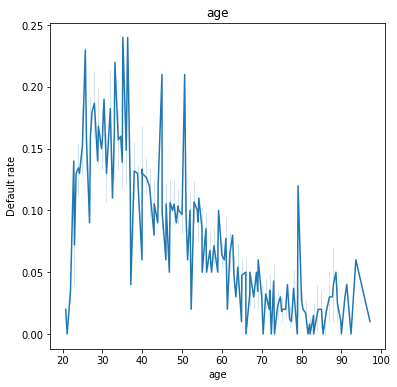

age - by value


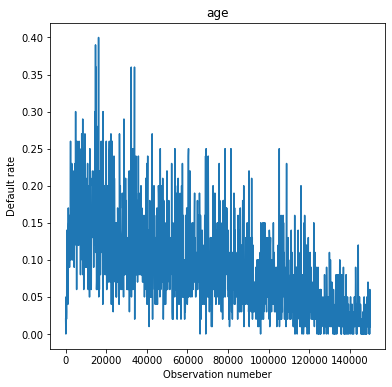

age - by index
----------------------------------------


In [16]:
# Plot 90+ clean vs age

plot_def_rate(['age'], 'times90_clean', 100)

In [17]:
# List variables for univariate analysis

train_vars = list(df.columns[1:])
for x in col_vars:    
    train_vars.remove(x)

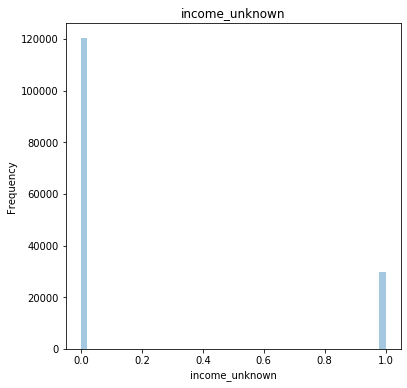

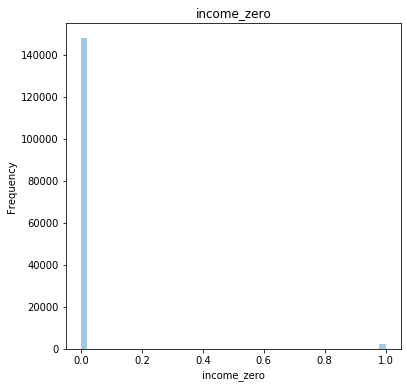

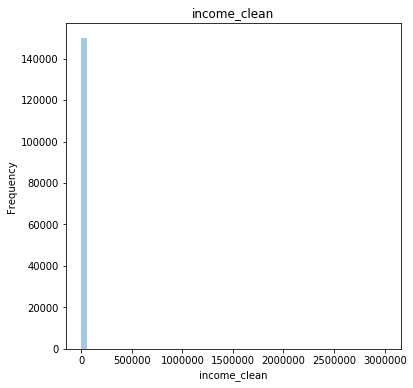

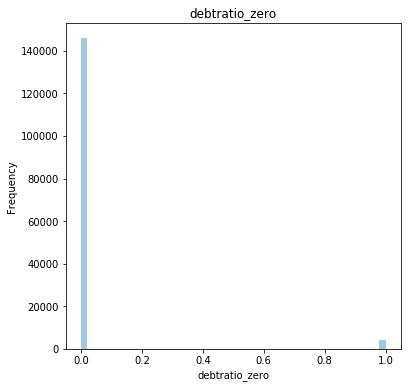

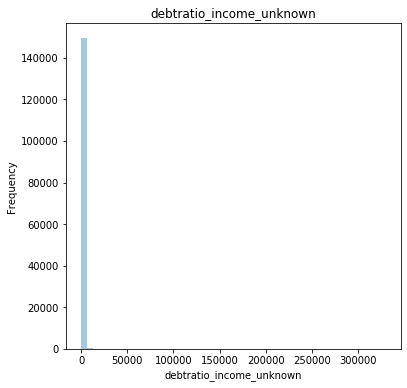

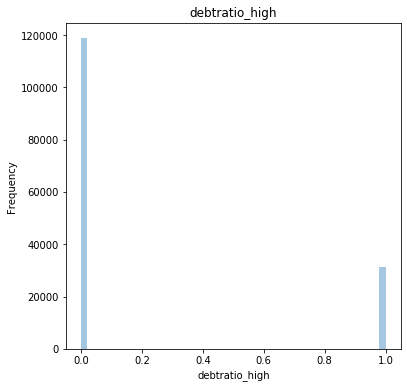

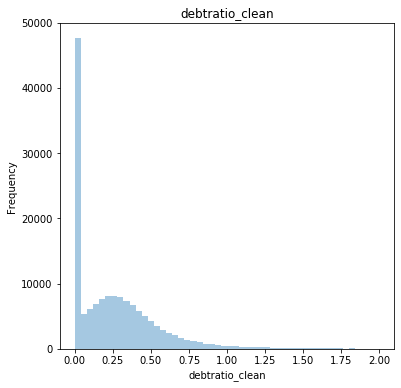

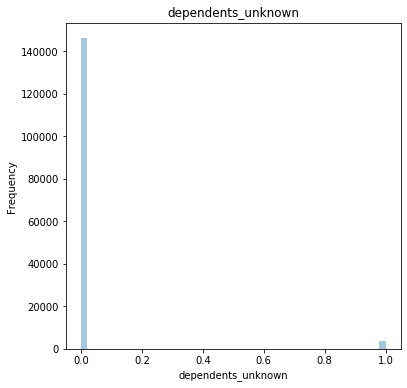

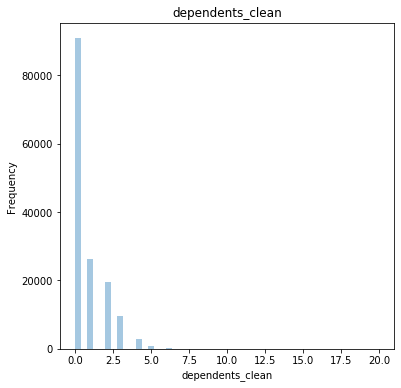

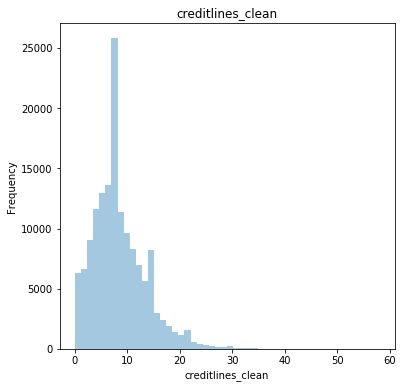

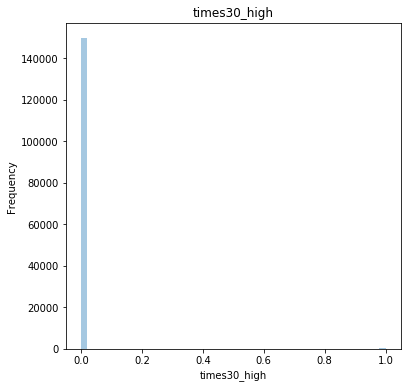

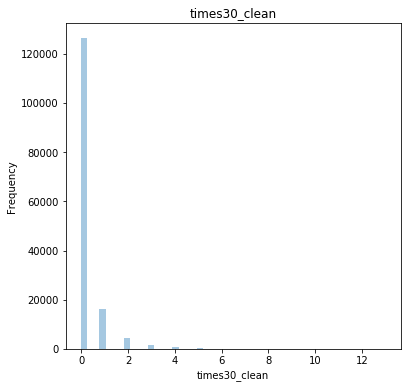

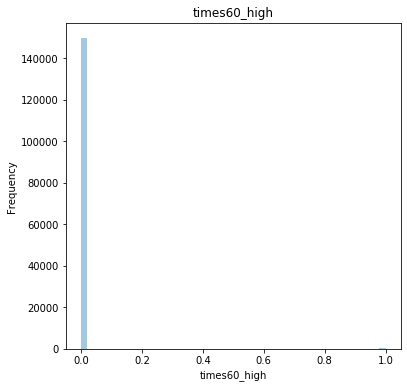

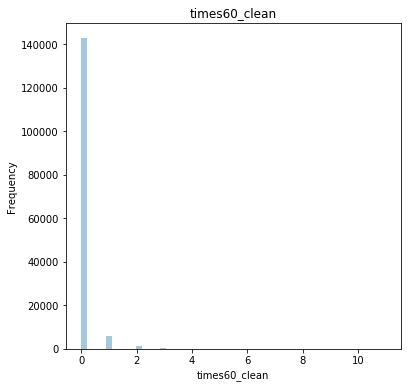

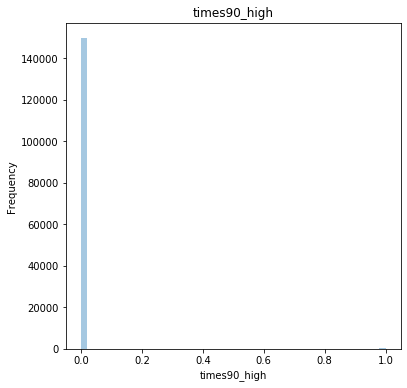

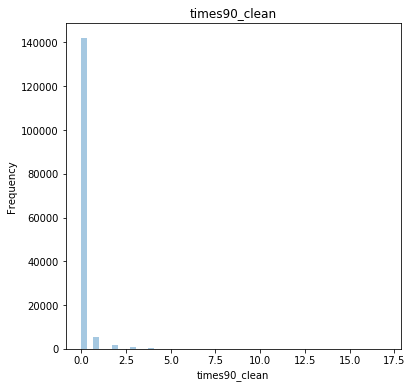

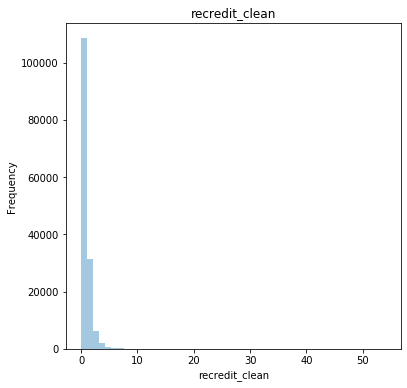

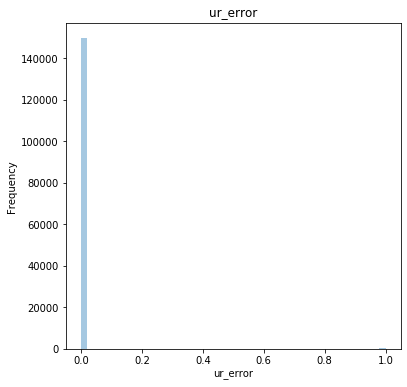

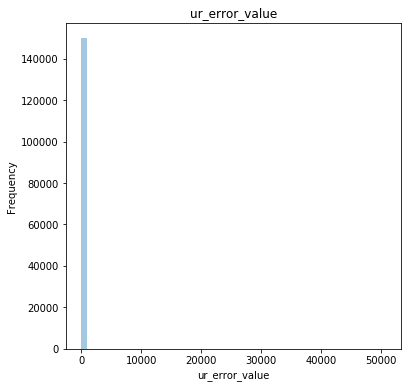

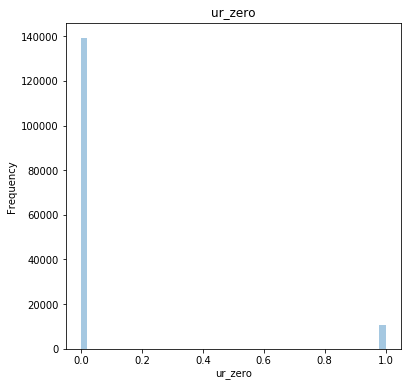

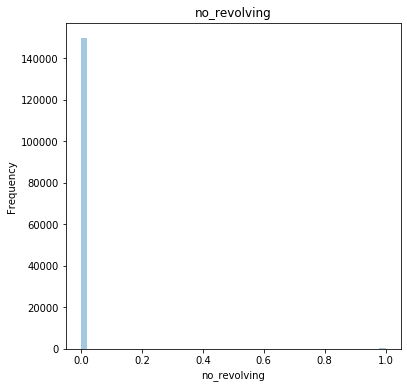

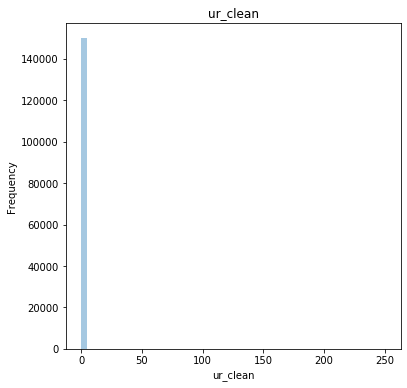

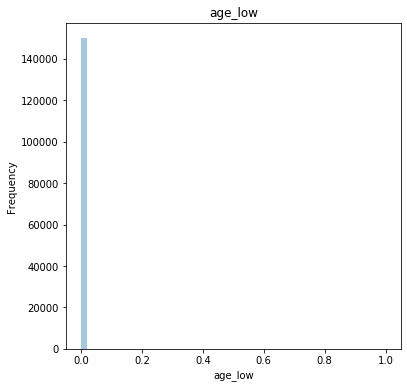

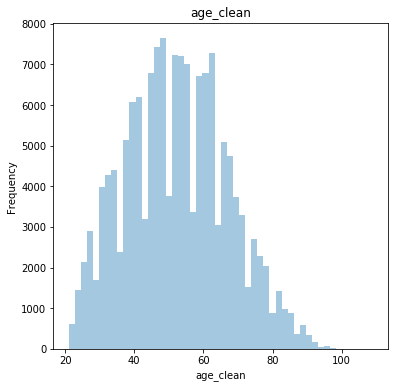

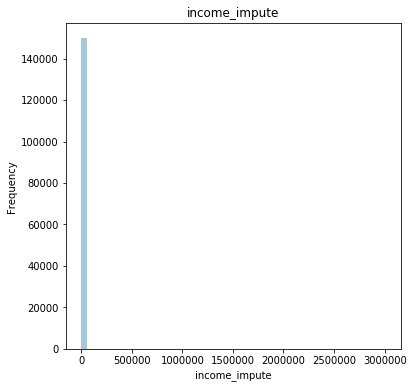

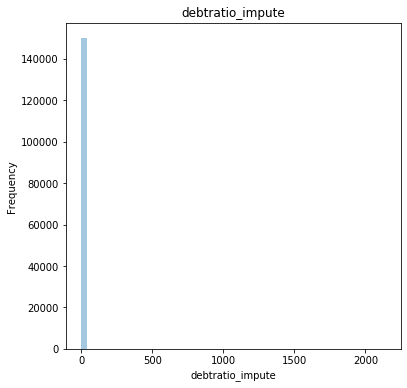

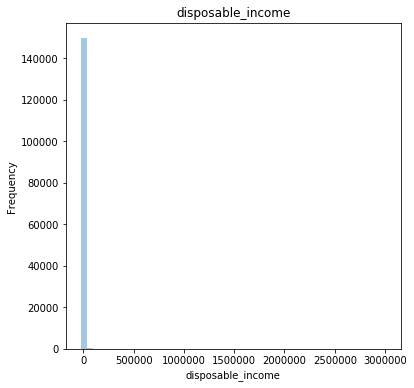

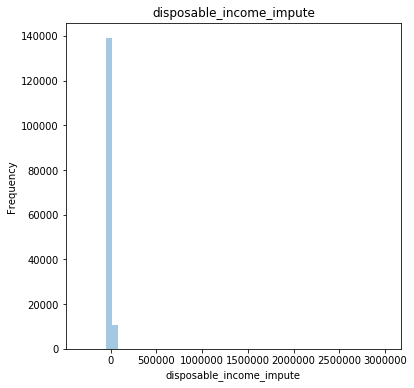

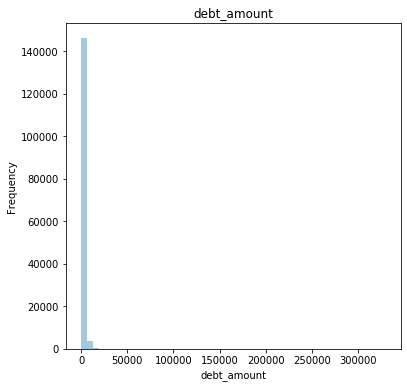

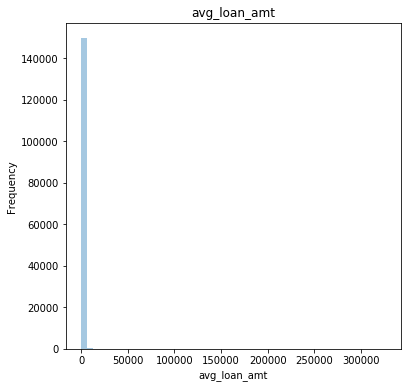

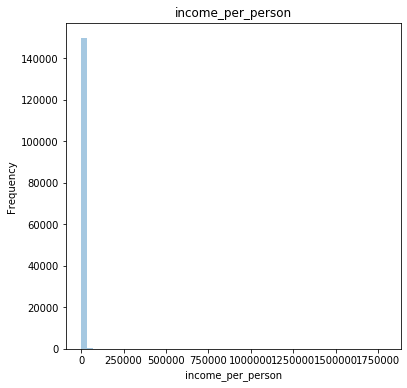

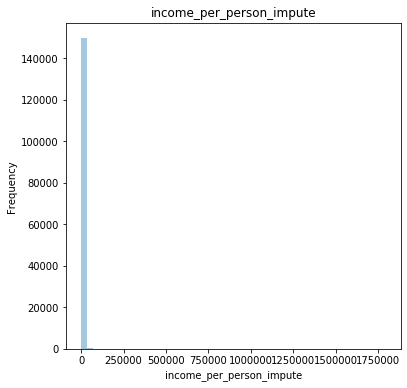

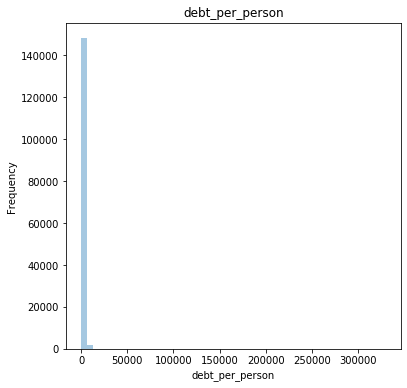

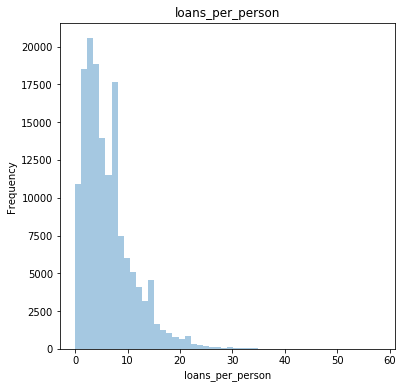

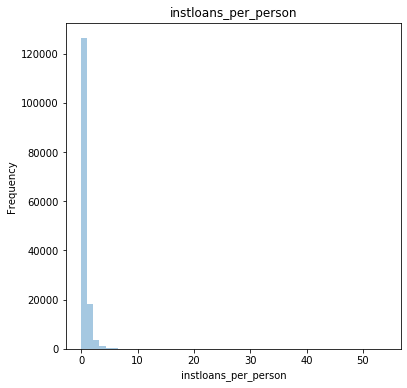

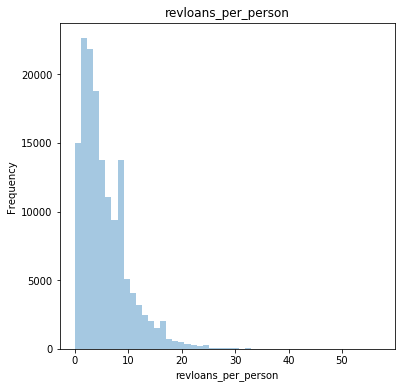

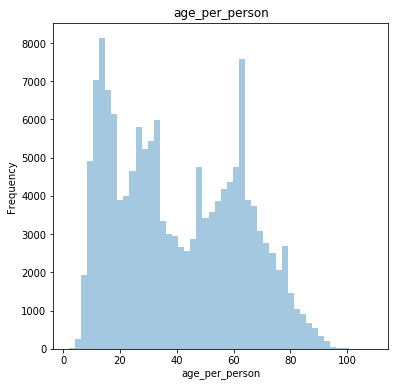

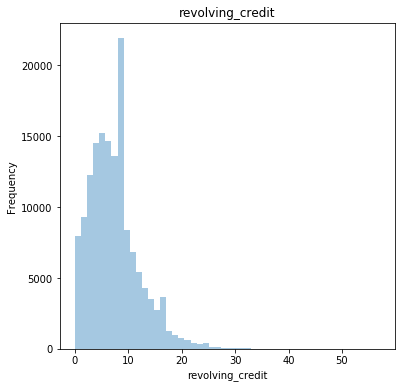

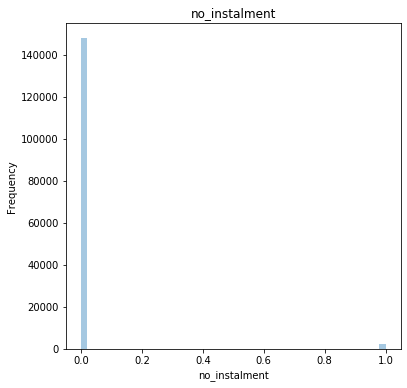

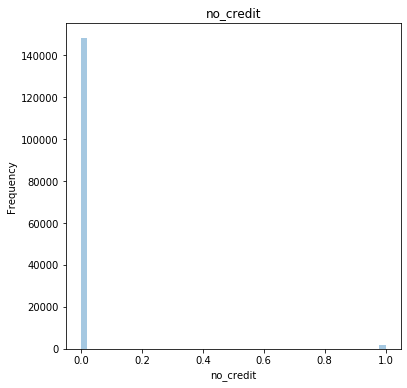

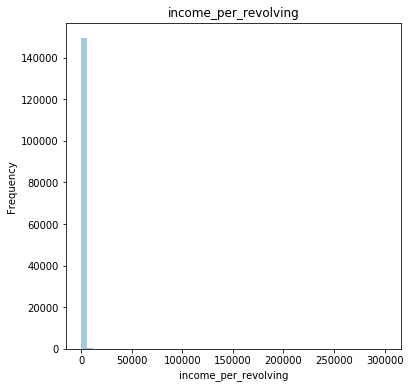

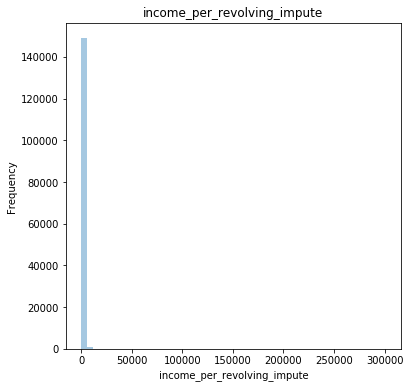

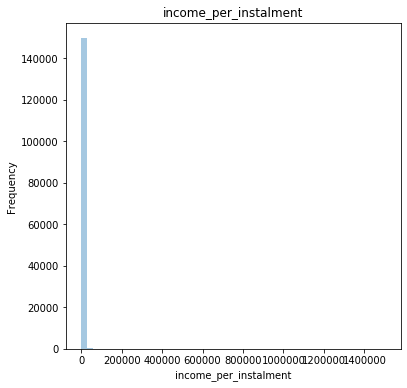

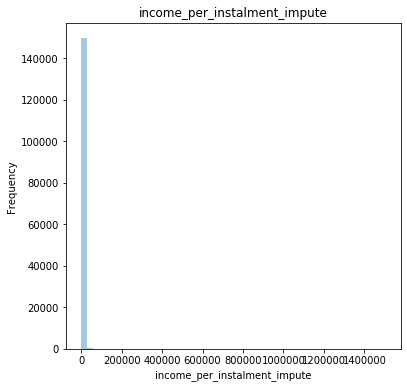

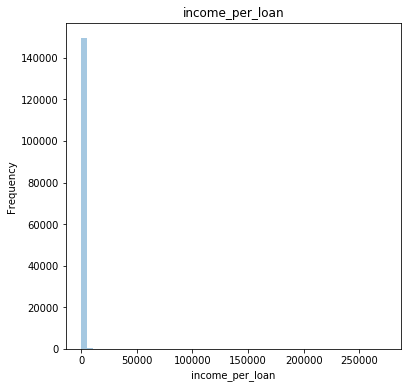

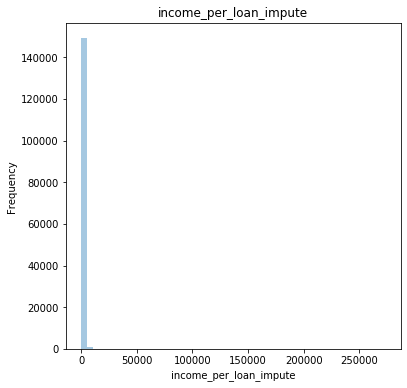

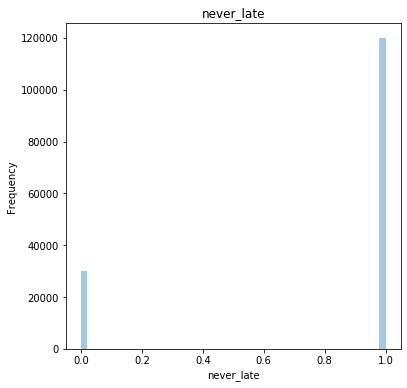

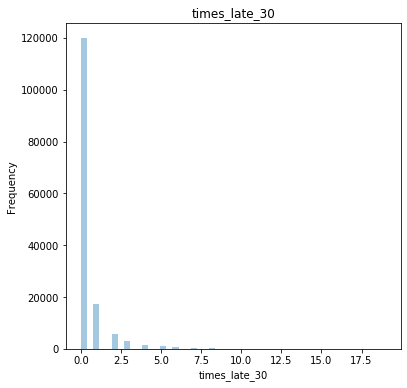

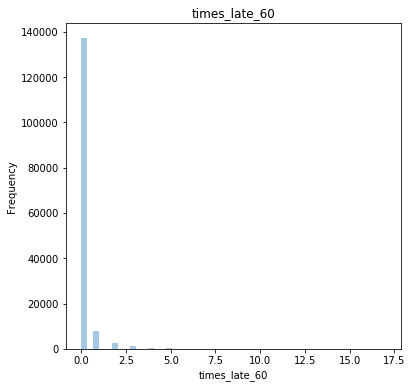

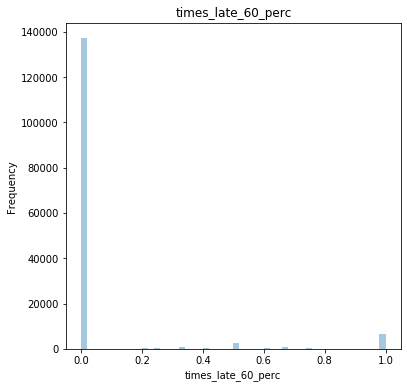

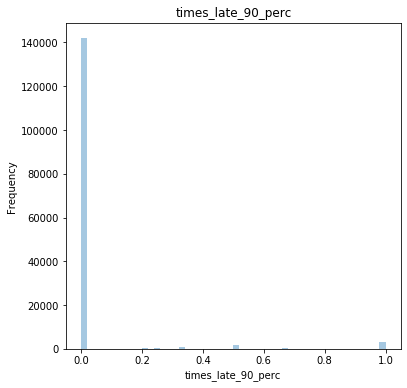

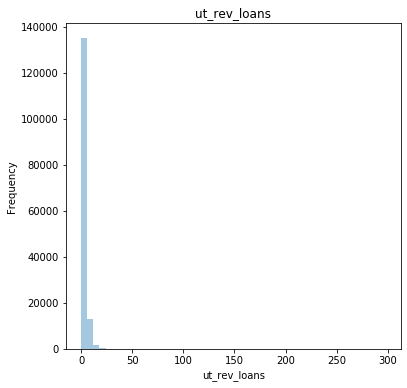

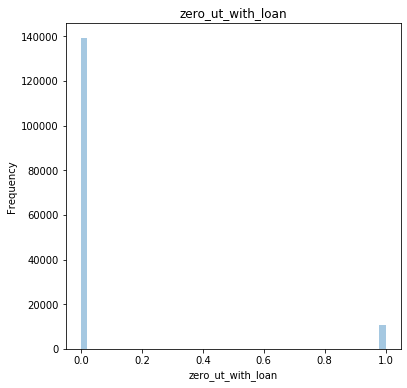

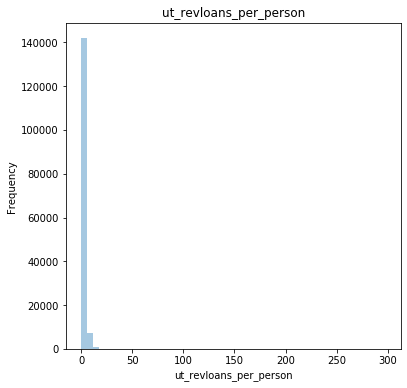

In [18]:
# Plot cleaned variable distributions

plot_dist(train_vars)

In [ ]:
# Plot cleaned variables vs default rate

plot_def_rate(train_vars, col_target, 1000)

In [19]:
# Calculate univariate gini

# Calculate univariate auc for cleaned variables
uni_auc_out = uni_auc(train_vars, col_target, 4, 6, 200)

# Calculate gini
uni_auc_out['gini'] = 2*(uni_auc_out['auc']-0.5)

# Show result
uni_auc_clean = uni_auc_out.sort_values(by = 'auc', ascending = False).reset_index(drop = True)
uni_auc_clean

,variable,auc,gini
0,times_late_30,0.767965,0.535931
1,ur_clean,0.766461,0.532922
2,never_late,0.746023,0.492046
3,ut_rev_loans,0.724770,0.449539
4,times_late_60,0.701204,0.402407
5,ut_revloans_per_person,0.700841,0.401682
6,times_late_60_perc,0.700274,0.400548
7,times30_clean,0.681854,0.363708
8,times_late_90_perc,0.650328,0.300656
9,times90_clean,0.650105,0.300210


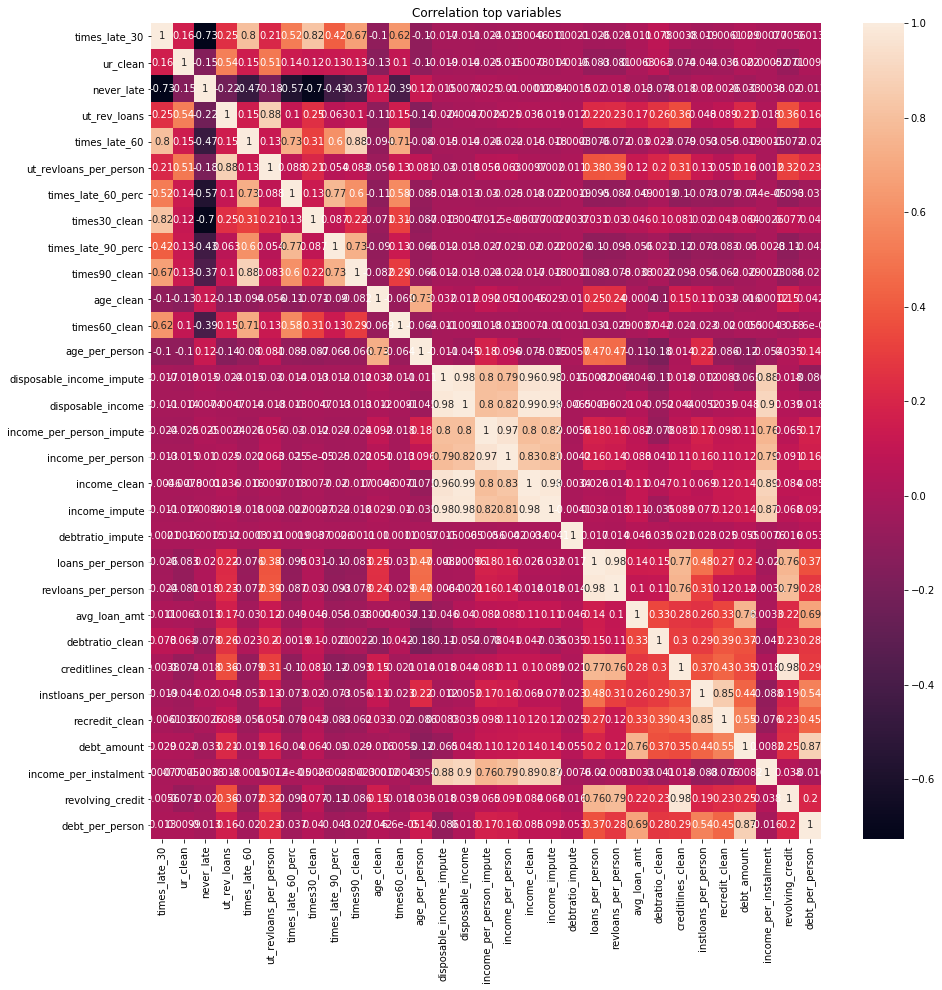

In [20]:
# Calculate correlation matrix for variables with high gini

# Set min gini to display
gini_min = 0.1

# Plot correlation
corr_matrix = df[uni_auc_clean['variable'][uni_auc_clean['gini'] >= gini_min]].corr()
fig, ax = plt.subplots(figsize=(15, 15))
plot = sns.heatmap(corr_matrix, annot=True, ax=ax)
plt.title("Correlation top variables")
plot.get_figure().savefig('output/' + 'correlation_top_variables.png')
plt.show()

In [21]:
# Predictor selection

# Set min gini/max correlation
gini_min = 0.1
corr_max = 0.9

# Get gini
gini_var = list(uni_auc_clean['variable'])
gini_val = list(uni_auc_clean['gini'])

# Variable selection
final_vars = []
for i,y in zip(gini_var, gini_val):
    print('-'*40)
    print('Variable:', i)
    if y < gini_min:
        print('Gini below:', gini_min)
        continue
    if not final_vars:
        final_vars.append(i)
        print('Variable added')
        continue
    corr_list = []
    for z in final_vars:
        corr = stat.pearsonr(df[i], df[z])
        corr_list.append(corr[0])
    if np.max(np.abs(corr_list)) > corr_max:
        print('Max correlation above', corr_max)
        continue
    final_vars.append(i)
    print('Variable added')

print('-'*40)
print('Number of variables for model input:', len(final_vars))
print('-'*40)
uni_auc_clean[uni_auc_clean['variable'].isin(final_vars)].reset_index(drop = True)

----------------------------------------
Variable: times_late_30
Variable added
----------------------------------------
Variable: ur_clean
Variable added
----------------------------------------
Variable: never_late
Variable added
----------------------------------------
Variable: ut_rev_loans
Variable added
----------------------------------------
Variable: times_late_60
Variable added
----------------------------------------
Variable: ut_revloans_per_person
Variable added
----------------------------------------
Variable: times_late_60_perc
Variable added
----------------------------------------
Variable: times30_clean
Variable added
----------------------------------------
Variable: times_late_90_perc
Variable added
----------------------------------------
Variable: times90_clean
Variable added
----------------------------------------
Variable: age_clean
Variable added
----------------------------------------
Variable: times60_clean
Variable added
----------------------------------

,variable,auc,gini
0,times_late_30,0.767965,0.535931
1,ur_clean,0.766461,0.532922
2,never_late,0.746023,0.492046
3,ut_rev_loans,0.724770,0.449539
4,times_late_60,0.701204,0.402407
5,ut_revloans_per_person,0.700841,0.401682
6,times_late_60_perc,0.700274,0.400548
7,times30_clean,0.681854,0.363708
8,times_late_90_perc,0.650328,0.300656
9,times90_clean,0.650105,0.300210


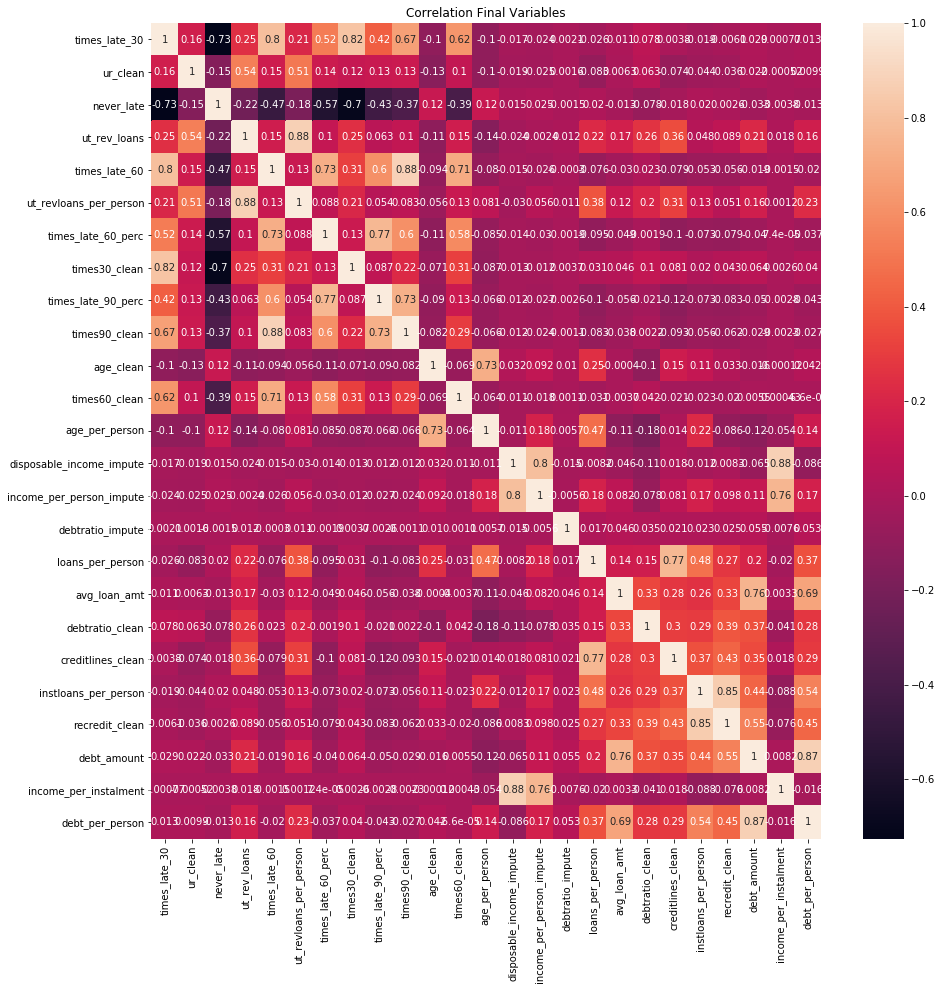

In [22]:
# Calculate correlation matrix for final variable list

corr_matrix = df[final_vars].corr()
fig, ax = plt.subplots(figsize=(15, 15))
plot = sns.heatmap(corr_matrix, annot=True, ax=ax)
plt.title("Correlation Final Variables")
plot.get_figure().savefig('output/' + 'correlation_final_variables.png')
plt.show()

In [23]:
# Split data into train/valid/test
x_train, x_reamin, y_train, y_reamin = train_test_split(df[final_vars], df[col_target], test_size=.2, random_state=3456)
x_test, x_valid, y_test, y_valid = train_test_split(x_reamin, y_reamin, test_size=.33, random_state=6543)

In [24]:
# Train parameters with CV and random search

# Define parameter space
param_space = {
'eta':[0.03, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.30],
'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
'max_depth':[3, 4, 5, 6, 7, 8, 9, 10],
'min_child_weight': [1, 5, 10, 20, 50, 100, 150, 200],
'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

# Create XGB Classifier
xgb_clf = xgb.XGBClassifier(eval_metric = 'auc', 
                            objective = 'binary:logistic', 
                            tree_method = 'gpu_hist', 
                            predictor = 'gpu_predictor')

# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgb_clf, 
                              param_distributions = param_space, 
                              scoring = 'roc_auc', 
                              verbose = 3, 
                              random_state = 5678, 
                              n_iter = 100
                             )

# Fit the model
cvmodel = xgb_rscv.fit(x_train, y_train)
       

print('Best score:', cvmodel.best_score_)
print('Best params: ', cvmodel.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] subsample=0.9, min_child_weight=1, max_depth=8, eta=0.2, colsample_bytree=0.5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.9, min_child_weight=1, max_depth=8, eta=0.2, colsample_bytree=0.5, score=0.861, total=   3.2s
[CV] subsample=0.9, min_child_weight=1, max_depth=8, eta=0.2, colsample_bytree=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV]  subsample=0.9, min_child_weight=1, max_depth=8, eta=0.2, colsample_bytree=0.5, score=0.843, total=   3.1s
[CV] subsample=0.9, min_child_weight=1, max_depth=8, eta=0.2, colsample_bytree=0.5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV]  subsample=0.9, min_child_weight=1, max_depth=8, eta=0.2, colsample_bytree=0.5, score=0.851, total=   2.7s
[CV] subsample=0.9, min_child_weight=1, max_depth=8, eta=0.2, colsample_bytree=0.5 
[CV]  subsample=0.9, min_child_weight=1, max_depth=8, eta=0.2, colsample_bytree=0.5, score=0.847, total=   2.8s
[CV] subsample=0.9, min_child_weight=1, max_depth=8, eta=0.2, colsample_bytree=0.5 
[CV]  subsample=0.9, min_child_weight=1, max_depth=8, eta=0.2, colsample_bytree=0.5, score=0.849, total=   2.7s
[CV] subsample=0.9, min_child_weight=50, max_depth=9, eta=0.2, colsample_bytree=0.5 
[CV]  subsample=0.9, min_child_weight=50, max_depth=9, eta=0.2, colsample_bytree=0.5, score=0.870, total=   1.9s
[CV] subsample=0.9, min_child_weight=50, max_depth=9, eta=0.2, colsample_bytree=0.5 
[CV]  subsample=0.9, min_child_weight=50, max_depth=9, eta=0.2, colsample_bytree=0.5, score=0.854, total=   1.9s
[CV] subsample=0.9, min_child_weight=50, max_depth=9, eta=0.2, colsample_bytree=0.5 
[CV]  subsample

[CV]  subsample=0.9, min_child_weight=100, max_depth=8, eta=0.15, colsample_bytree=0.6, score=0.862, total=   1.2s
[CV] subsample=1, min_child_weight=100, max_depth=10, eta=0.07, colsample_bytree=0.9 
[CV]  subsample=1, min_child_weight=100, max_depth=10, eta=0.07, colsample_bytree=0.9, score=0.873, total=   1.7s
[CV] subsample=1, min_child_weight=100, max_depth=10, eta=0.07, colsample_bytree=0.9 
[CV]  subsample=1, min_child_weight=100, max_depth=10, eta=0.07, colsample_bytree=0.9, score=0.857, total=   1.8s
[CV] subsample=1, min_child_weight=100, max_depth=10, eta=0.07, colsample_bytree=0.9 
[CV]  subsample=1, min_child_weight=100, max_depth=10, eta=0.07, colsample_bytree=0.9, score=0.861, total=   1.9s
[CV] subsample=1, min_child_weight=100, max_depth=10, eta=0.07, colsample_bytree=0.9 
[CV]  subsample=1, min_child_weight=100, max_depth=10, eta=0.07, colsample_bytree=0.9, score=0.862, total=   2.0s
[CV] subsample=1, min_child_weight=100, max_depth=10, eta=0.07, colsample_bytree=0.9 

[CV]  subsample=0.6, min_child_weight=150, max_depth=4, eta=0.25, colsample_bytree=0.7, score=0.857, total=   0.7s
[CV] subsample=0.6, min_child_weight=150, max_depth=4, eta=0.25, colsample_bytree=0.7 
[CV]  subsample=0.6, min_child_weight=150, max_depth=4, eta=0.25, colsample_bytree=0.7, score=0.859, total=   0.7s
[CV] subsample=0.6, min_child_weight=150, max_depth=4, eta=0.25, colsample_bytree=0.7 
[CV]  subsample=0.6, min_child_weight=150, max_depth=4, eta=0.25, colsample_bytree=0.7, score=0.861, total=   0.7s
[CV] subsample=0.6, min_child_weight=150, max_depth=4, eta=0.25, colsample_bytree=0.7 
[CV]  subsample=0.6, min_child_weight=150, max_depth=4, eta=0.25, colsample_bytree=0.7, score=0.862, total=   0.7s
[CV] subsample=0.7, min_child_weight=5, max_depth=8, eta=0.15, colsample_bytree=0.5 
[CV]  subsample=0.7, min_child_weight=5, max_depth=8, eta=0.15, colsample_bytree=0.5, score=0.866, total=   2.3s
[CV] subsample=0.7, min_child_weight=5, max_depth=8, eta=0.15, colsample_bytree=0

[CV]  subsample=1, min_child_weight=1, max_depth=6, eta=0.03, colsample_bytree=0.7, score=0.861, total=   1.7s
[CV] subsample=1, min_child_weight=1, max_depth=6, eta=0.03, colsample_bytree=0.7 
[CV]  subsample=1, min_child_weight=1, max_depth=6, eta=0.03, colsample_bytree=0.7, score=0.862, total=   1.6s
[CV] subsample=0.9, min_child_weight=50, max_depth=3, eta=0.25, colsample_bytree=0.7 
[CV]  subsample=0.9, min_child_weight=50, max_depth=3, eta=0.25, colsample_bytree=0.7, score=0.873, total=   0.7s
[CV] subsample=0.9, min_child_weight=50, max_depth=3, eta=0.25, colsample_bytree=0.7 
[CV]  subsample=0.9, min_child_weight=50, max_depth=3, eta=0.25, colsample_bytree=0.7, score=0.859, total=   0.7s
[CV] subsample=0.9, min_child_weight=50, max_depth=3, eta=0.25, colsample_bytree=0.7 
[CV]  subsample=0.9, min_child_weight=50, max_depth=3, eta=0.25, colsample_bytree=0.7, score=0.861, total=   0.7s
[CV] subsample=0.9, min_child_weight=50, max_depth=3, eta=0.25, colsample_bytree=0.7 
[CV]  sub

[CV]  subsample=0.7, min_child_weight=100, max_depth=3, eta=0.15, colsample_bytree=0.8, score=0.862, total=   0.7s
[CV] subsample=1, min_child_weight=200, max_depth=9, eta=0.15, colsample_bytree=0.6 
[CV]  subsample=1, min_child_weight=200, max_depth=9, eta=0.15, colsample_bytree=0.6, score=0.873, total=   1.3s
[CV] subsample=1, min_child_weight=200, max_depth=9, eta=0.15, colsample_bytree=0.6 
[CV]  subsample=1, min_child_weight=200, max_depth=9, eta=0.15, colsample_bytree=0.6, score=0.858, total=   1.3s
[CV] subsample=1, min_child_weight=200, max_depth=9, eta=0.15, colsample_bytree=0.6 
[CV]  subsample=1, min_child_weight=200, max_depth=9, eta=0.15, colsample_bytree=0.6, score=0.860, total=   1.3s
[CV] subsample=1, min_child_weight=200, max_depth=9, eta=0.15, colsample_bytree=0.6 
[CV]  subsample=1, min_child_weight=200, max_depth=9, eta=0.15, colsample_bytree=0.6, score=0.861, total=   1.3s
[CV] subsample=1, min_child_weight=200, max_depth=9, eta=0.15, colsample_bytree=0.6 
[CV]  su

[CV]  subsample=0.6, min_child_weight=50, max_depth=5, eta=0.05, colsample_bytree=0.8, score=0.857, total=   0.9s
[CV] subsample=0.6, min_child_weight=50, max_depth=5, eta=0.05, colsample_bytree=0.8 
[CV]  subsample=0.6, min_child_weight=50, max_depth=5, eta=0.05, colsample_bytree=0.8, score=0.862, total=   1.0s
[CV] subsample=0.6, min_child_weight=50, max_depth=5, eta=0.05, colsample_bytree=0.8 
[CV]  subsample=0.6, min_child_weight=50, max_depth=5, eta=0.05, colsample_bytree=0.8, score=0.862, total=   1.2s
[CV] subsample=0.6, min_child_weight=50, max_depth=5, eta=0.05, colsample_bytree=0.8 
[CV]  subsample=0.6, min_child_weight=50, max_depth=5, eta=0.05, colsample_bytree=0.8, score=0.863, total=   1.0s
[CV] subsample=0.5, min_child_weight=150, max_depth=4, eta=0.25, colsample_bytree=1 
[CV]  subsample=0.5, min_child_weight=150, max_depth=4, eta=0.25, colsample_bytree=1, score=0.872, total=   0.7s
[CV] subsample=0.5, min_child_weight=150, max_depth=4, eta=0.25, colsample_bytree=1 
[CV

[CV]  subsample=0.7, min_child_weight=50, max_depth=3, eta=0.3, colsample_bytree=0.9, score=0.860, total=   0.7s
[CV] subsample=0.7, min_child_weight=50, max_depth=3, eta=0.3, colsample_bytree=0.9 
[CV]  subsample=0.7, min_child_weight=50, max_depth=3, eta=0.3, colsample_bytree=0.9, score=0.861, total=   0.6s
[CV] subsample=1, min_child_weight=1, max_depth=5, eta=0.3, colsample_bytree=0.6 
[CV]  subsample=1, min_child_weight=1, max_depth=5, eta=0.3, colsample_bytree=0.6, score=0.867, total=   1.0s
[CV] subsample=1, min_child_weight=1, max_depth=5, eta=0.3, colsample_bytree=0.6 
[CV]  subsample=1, min_child_weight=1, max_depth=5, eta=0.3, colsample_bytree=0.6, score=0.853, total=   1.0s
[CV] subsample=1, min_child_weight=1, max_depth=5, eta=0.3, colsample_bytree=0.6 
[CV]  subsample=1, min_child_weight=1, max_depth=5, eta=0.3, colsample_bytree=0.6, score=0.854, total=   1.0s
[CV] subsample=1, min_child_weight=1, max_depth=5, eta=0.3, colsample_bytree=0.6 
[CV]  subsample=1, min_child_we

[CV]  subsample=0.7, min_child_weight=1, max_depth=9, eta=0.25, colsample_bytree=0.7, score=0.842, total=   4.3s
[CV] subsample=0.7, min_child_weight=1, max_depth=9, eta=0.25, colsample_bytree=0.7 
[CV]  subsample=0.7, min_child_weight=1, max_depth=9, eta=0.25, colsample_bytree=0.7, score=0.823, total=   4.3s
[CV] subsample=0.7, min_child_weight=1, max_depth=9, eta=0.25, colsample_bytree=0.7 
[CV]  subsample=0.7, min_child_weight=1, max_depth=9, eta=0.25, colsample_bytree=0.7, score=0.832, total=   4.2s
[CV] subsample=0.7, min_child_weight=1, max_depth=9, eta=0.25, colsample_bytree=0.7 
[CV]  subsample=0.7, min_child_weight=1, max_depth=9, eta=0.25, colsample_bytree=0.7, score=0.833, total=   4.2s
[CV] subsample=0.7, min_child_weight=1, max_depth=9, eta=0.25, colsample_bytree=0.7 
[CV]  subsample=0.7, min_child_weight=1, max_depth=9, eta=0.25, colsample_bytree=0.7, score=0.834, total=   4.2s
[CV] subsample=0.5, min_child_weight=5, max_depth=9, eta=0.25, colsample_bytree=0.6 
[CV]  subs

[CV]  subsample=0.5, min_child_weight=20, max_depth=6, eta=0.3, colsample_bytree=0.7, score=0.850, total=   1.3s
[CV] subsample=0.5, min_child_weight=20, max_depth=6, eta=0.3, colsample_bytree=0.7 
[CV]  subsample=0.5, min_child_weight=20, max_depth=6, eta=0.3, colsample_bytree=0.7, score=0.850, total=   1.3s
[CV] subsample=0.5, min_child_weight=20, max_depth=6, eta=0.3, colsample_bytree=0.7 
[CV]  subsample=0.5, min_child_weight=20, max_depth=6, eta=0.3, colsample_bytree=0.7, score=0.850, total=   1.3s
[CV] subsample=0.8, min_child_weight=5, max_depth=7, eta=0.3, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=5, max_depth=7, eta=0.3, colsample_bytree=0.6, score=0.857, total=   1.9s
[CV] subsample=0.8, min_child_weight=5, max_depth=7, eta=0.3, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=5, max_depth=7, eta=0.3, colsample_bytree=0.6, score=0.840, total=   1.9s
[CV] subsample=0.8, min_child_weight=5, max_depth=7, eta=0.3, colsample_bytree=0.6 
[CV]  subsample

[CV]  subsample=0.6, min_child_weight=100, max_depth=7, eta=0.15, colsample_bytree=0.6, score=0.862, total=   1.2s
[CV] subsample=1, min_child_weight=1, max_depth=9, eta=0.05, colsample_bytree=0.6 
[CV]  subsample=1, min_child_weight=1, max_depth=9, eta=0.05, colsample_bytree=0.6, score=0.870, total=   6.1s
[CV] subsample=1, min_child_weight=1, max_depth=9, eta=0.05, colsample_bytree=0.6 
[CV]  subsample=1, min_child_weight=1, max_depth=9, eta=0.05, colsample_bytree=0.6, score=0.855, total=   5.7s
[CV] subsample=1, min_child_weight=1, max_depth=9, eta=0.05, colsample_bytree=0.6 
[CV]  subsample=1, min_child_weight=1, max_depth=9, eta=0.05, colsample_bytree=0.6, score=0.859, total=   6.2s
[CV] subsample=1, min_child_weight=1, max_depth=9, eta=0.05, colsample_bytree=0.6 
[CV]  subsample=1, min_child_weight=1, max_depth=9, eta=0.05, colsample_bytree=0.6, score=0.860, total=   5.8s
[CV] subsample=1, min_child_weight=1, max_depth=9, eta=0.05, colsample_bytree=0.6 
[CV]  subsample=1, min_chi

[CV]  subsample=0.6, min_child_weight=20, max_depth=9, eta=0.1, colsample_bytree=0.6, score=0.856, total=   2.2s
[CV] subsample=0.6, min_child_weight=20, max_depth=9, eta=0.1, colsample_bytree=0.6 
[CV]  subsample=0.6, min_child_weight=20, max_depth=9, eta=0.1, colsample_bytree=0.6, score=0.859, total=   2.3s
[CV] subsample=0.6, min_child_weight=20, max_depth=9, eta=0.1, colsample_bytree=0.6 
[CV]  subsample=0.6, min_child_weight=20, max_depth=9, eta=0.1, colsample_bytree=0.6, score=0.860, total=   2.2s
[CV] subsample=0.6, min_child_weight=20, max_depth=9, eta=0.1, colsample_bytree=0.6 
[CV]  subsample=0.6, min_child_weight=20, max_depth=9, eta=0.1, colsample_bytree=0.6, score=0.860, total=   2.2s
[CV] subsample=0.8, min_child_weight=20, max_depth=4, eta=0.15, colsample_bytree=0.7 
[CV]  subsample=0.8, min_child_weight=20, max_depth=4, eta=0.15, colsample_bytree=0.7, score=0.873, total=   0.7s
[CV] subsample=0.8, min_child_weight=20, max_depth=4, eta=0.15, colsample_bytree=0.7 
[CV]  s

[CV]  subsample=0.7, min_child_weight=50, max_depth=4, eta=0.25, colsample_bytree=0.9, score=0.861, total=   0.8s
[CV] subsample=0.7, min_child_weight=50, max_depth=4, eta=0.25, colsample_bytree=0.9 
[CV]  subsample=0.7, min_child_weight=50, max_depth=4, eta=0.25, colsample_bytree=0.9, score=0.863, total=   0.8s
[CV] subsample=0.8, min_child_weight=200, max_depth=8, eta=0.2, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=200, max_depth=8, eta=0.2, colsample_bytree=0.6, score=0.873, total=   1.0s
[CV] subsample=0.8, min_child_weight=200, max_depth=8, eta=0.2, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=200, max_depth=8, eta=0.2, colsample_bytree=0.6, score=0.858, total=   1.1s
[CV] subsample=0.8, min_child_weight=200, max_depth=8, eta=0.2, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=200, max_depth=8, eta=0.2, colsample_bytree=0.6, score=0.860, total=   1.1s
[CV] subsample=0.8, min_child_weight=200, max_depth=8, eta=0.2, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 13.0min finished


Best score: 0.8641128023937064
Best params:  {'subsample': 0.7, 'min_child_weight': 50, 'max_depth': 6, 'eta': 0.07, 'colsample_bytree': 0.6}


In [25]:
# Set initial xgb parameters

params = {
'subsample': 0.5,
'min_child_weight': 5,
'max_depth': 3,
'eta': 0.1,
'colsample_bytree': 0.5,
'objective': 'binary:logistic',
'eval_metric': 'auc',
'tree_method': 'gpu_hist', 
'predictor': 'gpu_predictor'
}

# Set max number of iterations
max_rounds = 1000

# Set early stopping parameter
stop_rounds = 30

In [26]:
# Replace parameters with tuned parameters

for x in cvmodel.best_params_:
    params[x] = cvmodel.best_params_[x]
    
print('New params:')
params

New params:


{'subsample': 0.7,
 'min_child_weight': 50,
 'max_depth': 6,
 'eta': 0.07,
 'colsample_bytree': 0.6,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor'}

In [27]:
# Load xgb DMatrix

dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)
dtest = xgb.DMatrix(x_test, label=y_test)

In [28]:
# Train final model

model = xgb.train(
    params,
    dtrain,
    num_boost_round = max_rounds,
    evals=[(dtrain,'train'), (dvalid, 'valid')],
    early_stopping_rounds = stop_rounds
)

pred_valid = model.predict(dtest)

[0]	train-auc:0.85047	valid-auc:0.86079
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 30 rounds.
[1]	train-auc:0.85479	valid-auc:0.86520
[2]	train-auc:0.85841	valid-auc:0.86478
[3]	train-auc:0.85907	valid-auc:0.86638
[4]	train-auc:0.85948	valid-auc:0.86728
[5]	train-auc:0.86114	valid-auc:0.86851
[6]	train-auc:0.86142	valid-auc:0.86868
[7]	train-auc:0.86176	valid-auc:0.86902
[8]	train-auc:0.86290	valid-auc:0.87053
[9]	train-auc:0.86312	valid-auc:0.87044
[10]	train-auc:0.86391	valid-auc:0.87146
[11]	train-auc:0.86422	valid-auc:0.87151
[12]	train-auc:0.86457	valid-auc:0.87175
[13]	train-auc:0.86472	valid-auc:0.87214
[14]	train-auc:0.86504	valid-auc:0.87202
[15]	train-auc:0.86504	valid-auc:0.87257
[16]	train-auc:0.86528	valid-auc:0.87301
[17]	train-auc:0.86529	valid-auc:0.87310
[18]	train-auc:0.86556	valid-auc:0.87377
[19]	train-auc:0.86569	valid-auc:0.87367
[20]	train-auc:0.86593	valid-auc:0.87385
[21]	t

Feature importance by weight


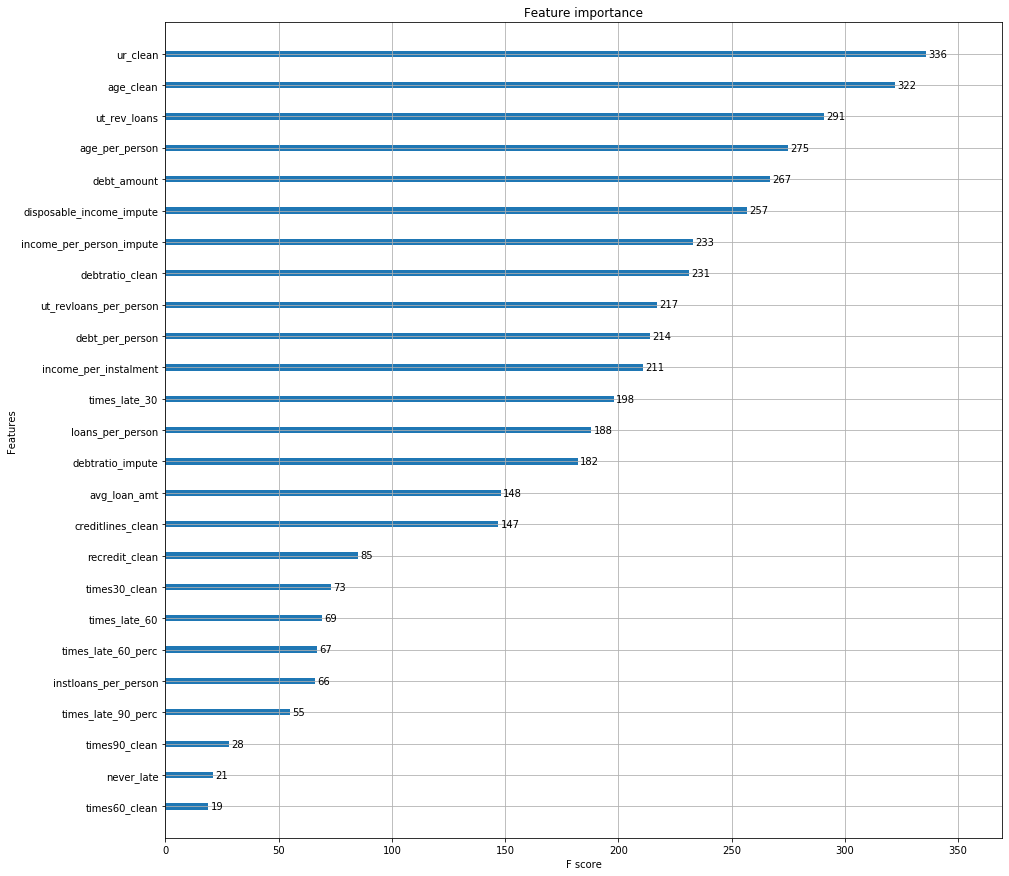

----------------------------------------------------------------------------------------------------
Feature importance by gain


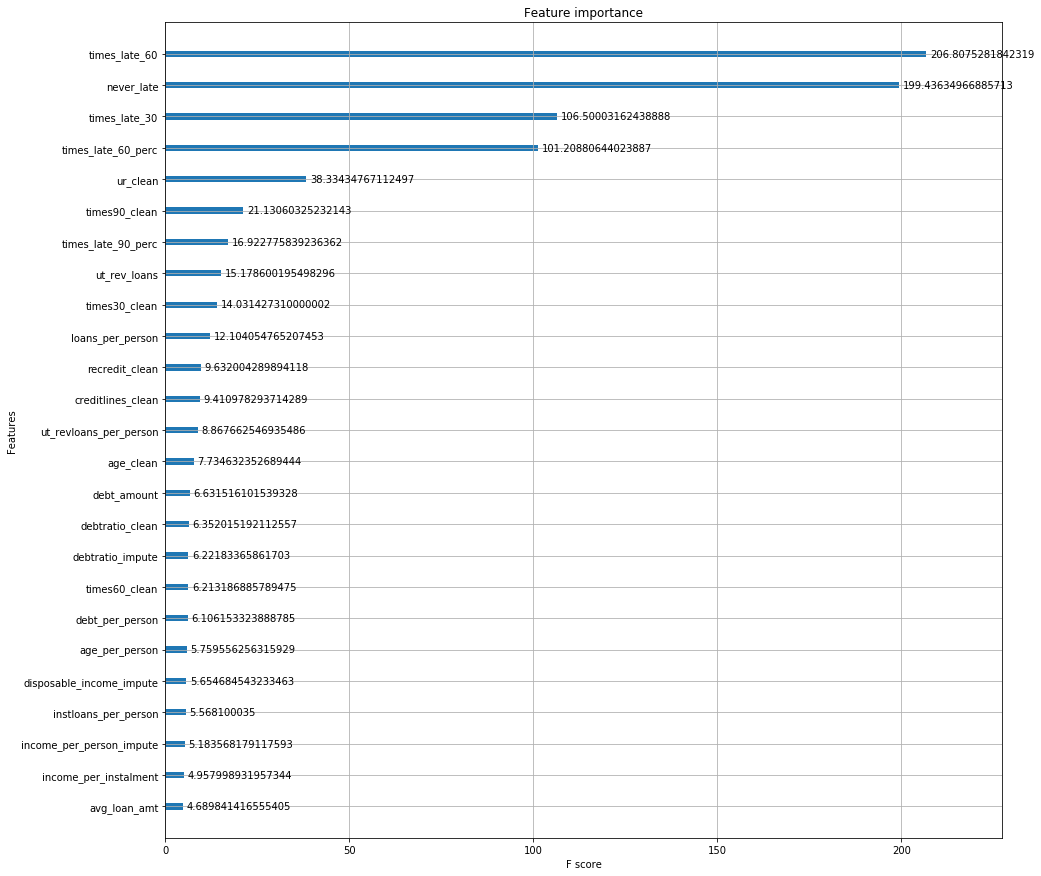

In [29]:
# Get feature importance plot and model gini

# By weight
print('Feature importance by weight')
fig, ax = plt.subplots(figsize=(15, 15))
plot = xgb.plot_importance(model, importance_type='weight', ax=ax)
plot.get_figure().savefig('output/' + 'feature_importance_weight.png')
plt.show()
print('-'*100)

# By gain
print('Feature importance by gain')
fig, ax = plt.subplots(figsize=(15, 15))
plot = xgb.plot_importance(model, importance_type='gain', ax=ax)
plot.get_figure().savefig('output/' + 'feature_importance_weight.png')
plt.show()

In [30]:
# Model auc

# Calculate auc/gini
auc = roc_auc_score(y_test, pred_valid)
gini = 2*(auc-0.5)

print('auc:', auc)
print('gini:', gini)

auc: 0.8698950658947311
gini: 0.7397901317894622


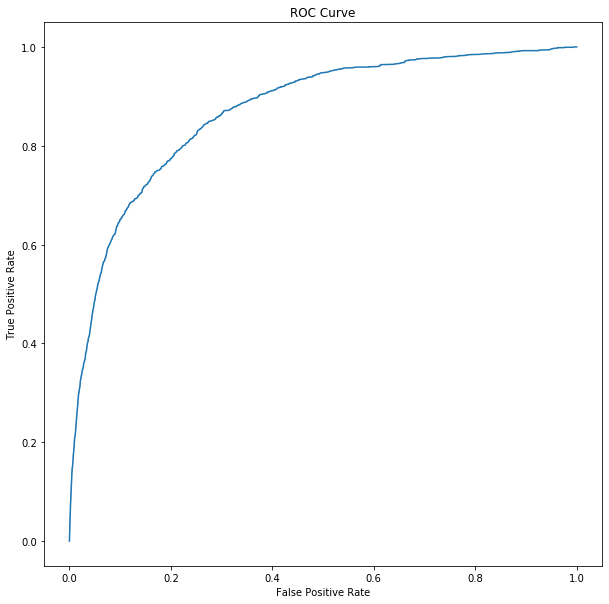

In [31]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred_valid)

fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.lineplot(fpr, tpr, ax=ax)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plot.get_figure().savefig('output/' + 'ROC_curve.png')
plt.show()

Model lift 5%: 7.195767195767196
Model lift 10%: 5.646258503401361
----------------------------------------
Model calibration plot
R2: 0.9994167542389942


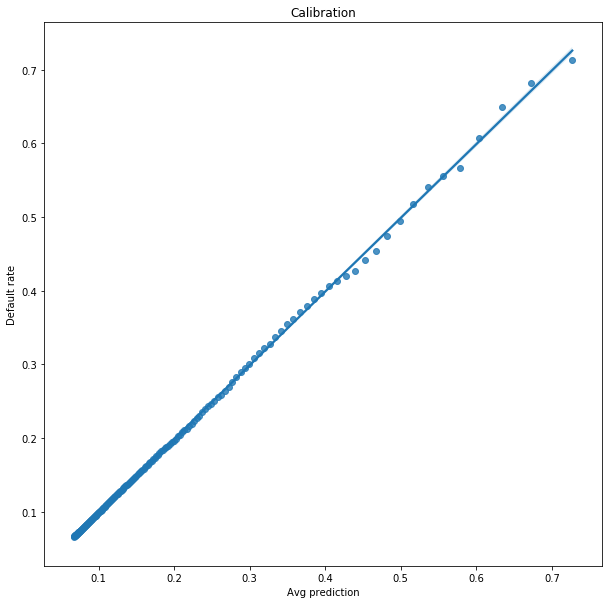

In [32]:
# Model lift/Calibration

# Combine prediction/result
model_output = pd.DataFrame()
model_output['target'] = y_test
model_output['pred'] = pred_valid

# Define initial list
model_lift = []
avg_score = []
avg_bad_rate = []

# sample bad rate
bad_rate = model_output['target'].mean()

# Calc bad rate/avg score/lift at each percentile
for x in [x/200 for x in range(1,200)]:
    y = 1-x
    quant = model_output['pred'].quantile(y)
    obs = model_output['target'][model_output['pred'] > quant].count()
    model_avg = model_output['pred'][model_output['pred'] > quant].mean()
    x_bad_rate = model_output['target'][model_output['pred'] > quant].mean()
    lift = x_bad_rate/bad_rate
    
    # Append results
    model_lift.append(lift)
    avg_score.append(model_avg)
    avg_bad_rate.append(x_bad_rate)
    
# Put results into dataset
lift_all = pd.DataFrame()
lift_all['percentile'] = [x/200 for x in range(1,200)]
lift_all['model'] = model_lift

# Model lift @ 5/10%
print('Model lift 5%:', model_lift[9])
print('Model lift 10%:', model_lift[19])
print('-'*40)

# Plot model calibration
print('Model calibration plot')
print('R2:', r2_score(avg_bad_rate, avg_score))
fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.regplot(avg_score, avg_bad_rate, ax=ax);
plt.title("Calibration")
plt.xlabel("Avg prediction")
plt.ylabel("Default rate")
plot.get_figure().savefig('output/' + 'Model_Calibrarion.png')
plt.show()

In [33]:
# Key variable lift

# Define variables to calculate lift
lift_vars = ['times90_clean','times_late_60','times_late_30','ur_clean','debtratio_clean']

# Prepare dataset
lift_data = x_test[lift_vars].copy()
lift_data['target'] = y_test

# Loop variables
for var in lift_vars:
    # Define initial list
    var_lift = []
    # Calc lift at each percentile
    for x in [x/200 for x in range(1,200)]:
        y = int(x*lift_data.shape[0])
        temp = lift_data[['target', var]].sort_values(by = var, ascending = False).reset_index().copy()
        obs = temp['target'][0:y].count()
        x_bad_rate = temp['target'][0:y].mean()
        lift = x_bad_rate/bad_rate
        
        # Append results
        var_lift.append(lift)

    # Put results into dataset
    lift_all[var] = var_lift

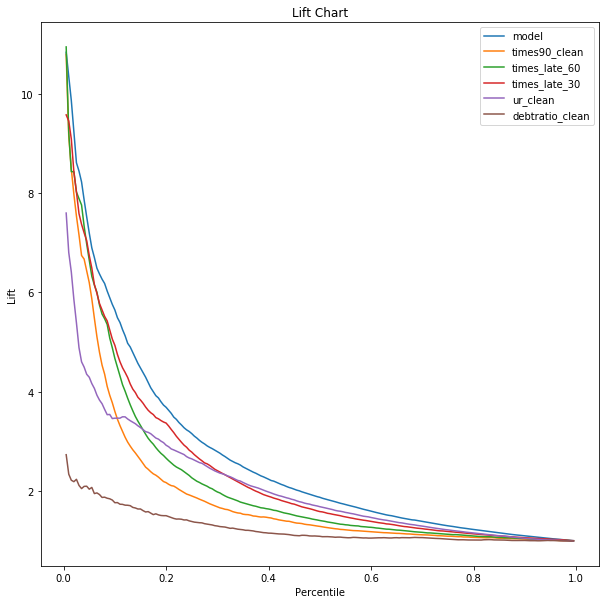

----------------------------------------
Lift table


,percentile,model,times90_clean,times_late_60,times_late_30,ur_clean,debtratio_clean
0,0.005000,10.830471,10.786848,10.938776,9.571429,7.596372,2.734694
1,0.010000,10.355253,9.145881,9.221466,9.448224,6.802721,2.343159
2,0.015000,9.860191,8.479671,8.429197,9.085362,6.410227,2.220866
3,0.020000,9.221466,7.974301,8.427816,8.427816,5.857899,2.191988
4,0.025000,8.608215,7.535843,8.020074,8.020074,5.387069,2.239568
5,0.030000,8.440413,7.155455,7.886117,7.583774,4.887881,2.116402
6,0.035000,8.222209,6.742726,7.758457,7.369453,4.603207,2.053073
7,0.040000,7.860922,6.670446,7.331822,7.199546,4.497354,2.097506
8,0.045000,7.520828,6.436749,6.974545,7.041770,4.352788,2.100767
9,0.050000,7.195767,6.198035,6.651550,6.742252,4.293273,2.040816


In [34]:
# Visualise lifts

# Define output style
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Graph
fig, ax = plt.subplots(figsize=(10, 10))
for y in list(lift_all.columns[1:]):
    plot = sns.lineplot(x = 'percentile', y = y, data = lift_all, ax=ax)
plt.title('Lift Chart')
plt.xlabel('Percentile')
plt.ylabel('Lift')
ax.legend(labels=list(lift_all.columns[1:]))
plt.show()
plot.get_figure().savefig('output/' + 'lift_plot.png')

# Display table
print('-'*40)
print('Lift table')
display(lift_all.style.apply(highlight_max, axis=1))